# MRM for Fraud in Finance

In [2]:
# General
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
import glob
import typing
from typing import Union, Tuple, Dict, List, Type, Union
import copy


# Models
from sklearn.linear_model import LogisticRegression
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
import lightgbm as lgb
from sklearn.neural_network import MLPClassifier
from fraudmrm.mlp import BinaryMLP1L
from fraudmrm.utils import train_mlp, test_mlp
#import xgboost as xgb
#from xgboost import XGBClassifier

# Preprocess model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from category_encoders import TargetEncoder, CountEncoder
# from statsmodels.stats.outliers_influence import variance_inflation_factor
from imblearn.over_sampling import SMOTENC#, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.impute import SimpleImputer

# Model performance metrics
from sklearn.metrics import (
    recall_score, precision_score, average_precision_score,
    f1_score, precision_recall_curve, roc_auc_score, roc_curve
)

# Explainability
import shap
# from lime.lime_tabular import LimeTabularExplainer
from sklearn.inspection import permutation_importance
# from sklearn.inspection import PartialDependenceDisplay
# from sklearn import tree


# Others
# import logging
import pickle
import importlib

In [3]:
FIG_PATH = '../figures/'
RESULT_PATH = '../results/'
DATA_PATH = '/Users/efonesca.dos.reis/mrm_fraud/datasets/fdb_ieee/'

# Load data

In [4]:
def load_data(path, file_name):
    df = pd.read_csv(path+file_name)
    return df

In [5]:
%%time
# Load data
file_name = 'ieeecis_train.csv'
train_df = load_data(DATA_PATH, file_name)

# Load data
file_name = 'ieeecis_test.csv'
test_df = load_data(DATA_PATH, file_name)

# Load labels
file_name = 'ieeecis_test_labels.csv'
test_labels_df = load_data(DATA_PATH, file_name)

# Add fraud labels
test_df = pd.merge(test_df, test_labels_df, on=['TransactionID', 'EVENT_ID'], how='inner')

CPU times: user 1.76 s, sys: 277 ms, total: 2.03 s
Wall time: 2.08 s


# Preporcess data

/var/folders/x6/nm550mg94y75s74djxxkq6kw0000gr/T/ipykernel_53848/2714559589.py:13: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df.insert(2, 'week', df['transactionTime'].dt.to_period('W-MON'))


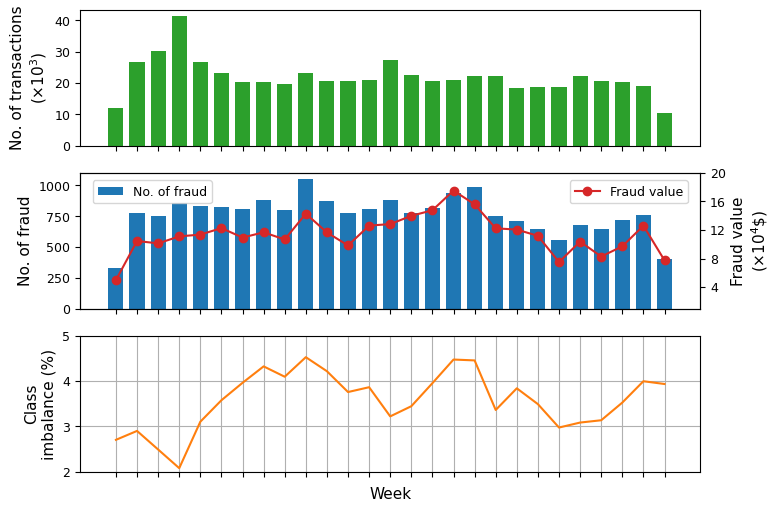

CPU times: user 1.33 s, sys: 124 ms, total: 1.45 s
Wall time: 1.09 s


In [10]:
%%time

# Concatenate train and test datasets
df = pd.concat([train_df, test_df])

# Preprocess data
preprocess_data(df)

# Plot
plot_fraud_barline(df, tw='week', width=5)

In [7]:
def add_time(df):
    # Add transaction time column
    eventTime = pd.to_datetime(df.EVENT_TIMESTAMP)
    df.insert(1, 'transactionTime', eventTime)

    # Sort dataframe by transaction time
    df.sort_values(by='transactionTime', inplace=True)

    # General temporal features
    df.insert(2, 'hour', df['transactionTime'].dt.hour.astype('category'))
    df.insert(2, 'weekday', df['transactionTime'].dt.dayofweek.astype('category'))
    df.insert(2, 'day', df['transactionTime'].dt.date)
    df.insert(2, 'week', df['transactionTime'].dt.to_period('W-MON'))
    df.insert(2, 'month', df['transactionTime'].dt.month)
    # df.insert(2, 'year', df['transactionTime'].dt.year)
def rename_columns(df):
    # Rename columns
    df.rename(columns={'EVENT_LABEL':'isFraud', 
                       'transactionamt':'Amount'},
              inplace=True)
    if df.columns.get_loc('isFraud') != len(df.columns):
        df['isFraud'] = df.pop('isFraud')
def remove_columns(df):
    # Remove unused columns
    # if np.isin('LABEL_TIMESTAMP', df.columns):
        # df.drop(['LABEL_TIMESTAMP'], axis=1, inplace=True)
    # Remove unused columns
    df.drop(['EVENT_ID', 'ENTITY_ID', 'EVENT_TIMESTAMP', 'ENTITY_TYPE', 'LABEL_TIMESTAMP'], axis=1, inplace=True)

def preprocess_data(df):
    add_time(df)
    rename_columns(df)
    remove_columns(df)

In [9]:
def plot_fraud_barline(data, tw=None, width=None):

    axis_label_fs = 11
    axis_tick_fs = 9
    legend_fs = 9
    title_fs = 9
    
    fig, ax = plt.subplots(3, 1, figsize=(8, 6), sharex=True)

    # Total number of transactions
    ntx = data.groupby(tw)['isFraud'].count()
    if tw == 'week':
        ntx.index = ntx.index.start_time
    ax[0].bar(ntx.index, ntx.values/1e3, color='C2', width=width)

    # Number and value of fraud
    x = data.groupby(tw, as_index=True)['isFraud'].sum()
    y = data.loc[data.isFraud == 1].groupby(tw)['Amount'].sum()
    if tw == 'week':
        x.index = x.index.start_time
        y.index = y.index.start_time
    ax[1].bar(x.index, x.values, width=width, label='No. of fraud')
    ax11 = ax[1].twinx()
    ax11.plot(y.index, y.values/1e4, c='tab:red', marker='o', label='Fraud value')
    
     # Class imbalance
    fraud_imb = 100*data.groupby(tw)['isFraud'].sum()/data.groupby(tw)['isFraud'].count()
    if tw == 'week':
        fraud_imb.index = fraud_imb.index.start_time
    ax[2].plot(fraud_imb.index, fraud_imb.values, color='C1')

    
    # Formatting
    
    ax[1].set_ylabel('No. of fraud', fontsize=axis_label_fs)
    ax[1].legend(loc='upper left', bbox_to_anchor=(0.01, 0.99), fontsize=legend_fs)
    # ax[1].set_title('(a)', fontsize=title_fs, loc='left')
    ax11.set_ylabel('Fraud value\n'+r'$(\times 10^4 \$)$', fontsize=axis_label_fs)
    ax11.legend(loc='upper right', bbox_to_anchor=(0.99, 0.99), fontsize=legend_fs)
    ax11.set_yticks(np.arange(4, 22, 4), np.arange(4, 22, 4))
    ax11.set_ylim(bottom=1)
    
    ax[2].grid(axis='both')
    # ax[2].set_title('(b)', loc='left', fontsize=title_fs)
    ax[2].set_ylabel('Class\nimbalance (%)', fontsize=axis_label_fs)
    ax[2].set_ylim(bottom=2, top=5)
    ax[2].set_xticks(x.index, x.index, rotation=90, fontsize=axis_tick_fs)
    ax[2].set_xlabel(tw.title(), fontsize=axis_label_fs)
    
    ax[0].set_ylabel('No. of transactions\n'+r'$(\times 10^3)$', fontsize=axis_label_fs)
    # ax[0].set_title('(c)', loc='left', fontsize=title_fs)
    ax[0].set_xticks(x.index, '' if tw=='week' else x.index, rotation=45, ha='right', fontsize=axis_tick_fs)
    
    ax[0].tick_params(labelsize=axis_tick_fs)
    ax11.tick_params(labelsize=axis_tick_fs)
    ax[1].tick_params(labelsize=axis_tick_fs)
    ax[2].tick_params(labelsize=axis_tick_fs)
    
    plt.subplots_adjust(hspace=0.2)
    # plt.savefig(fig_folder+'TabFormer_dataset.png', bbox_inches='tight', dpi=300)
    plt.show()

# Missing values

Missing values handling:
- Compute the fraction of missing values of fraud cases with respect to all fraud cases for each variable. Do the same for non-fraud cases.
- Add missingness indicator for variables where the difference between the fraction of fraud and non-fraud is higher than 0.05, and non-fraud cases have less 0.3 missing values.
- Variables found with this criterion: ['addr1', 'v62', 'v70', 'v76', 'v78', 'v82', 'v91']
- Remove variables with more than 0.3 missing values

In [12]:
%%time
df = handle_missing(df)

CPU times: user 4.01 s, sys: 1.23 s, total: 5.24 s
Wall time: 5.24 s


In [11]:
def handle_missing(df: pd.DataFrame) -> pd.DataFrame:
    # Fraction of missing values
    missing_values = df.isna().sum()/len(df)
    df_miss = pd.DataFrame(missing_values.loc[missing_values != 0], columns=['frac'])\
                .reset_index().rename(columns={'index':'feature'})
    # Fraction of missing values for fraud and non-fraud
    frac_missing=[]
    for col in df_miss['feature']:
        dfA = df[[col, 'isFraud']]
        frac_fraud_missing = len(dfA.loc[(dfA[col].isna()) & (dfA['isFraud'] == 1)])/len(df.loc[df['isFraud']==1])
        frac_nonfraud_missing = len(dfA.loc[(dfA[col].isna()) & (dfA['isFraud'] == 0)])/len(df.loc[df['isFraud']==0])
        frac_missing.append([col, frac_fraud_missing, frac_nonfraud_missing])
    frac_missing = pd.DataFrame(frac_missing, columns=['feature', 'fraud_frac', 'nonfraud_frac'])
    df_miss = df_miss.merge(frac_missing, on='feature', how='left').sort_values(by='frac', ascending=False)

    # Variables to add missingness
    missingness_vars = frac_missing.loc[(frac_missing['fraud_frac'] - frac_missing['nonfraud_frac'] > 0.05) &\
                 (frac_missing['nonfraud_frac'] < 0.3)]['feature'].to_list()
    # Add missingness indicator variable
    for var in missingness_vars:
        df[var+'_missing'] = df[var].isna().astype(int)
        
    # Remove columns with more than or equal 0.3 missing values
    df.drop(df.columns[df.isna().sum()/len(df) >= 0.3].to_list(), axis=1, inplace=True)

    return df

Visual

In [237]:
def missing(df):
    # Fraction of missing values
    missing_values = df.isna().sum()/len(df)
    df_miss = pd.DataFrame(missing_values.loc[missing_values != 0], columns=['frac'])\
                .reset_index().rename(columns={'index':'feature'})
    df_miss = df_miss.merge(get_frac_missing(df), on='feature', how='left').sort_values(by='frac', ascending=False)
    return df_miss

def plot_missing(df, ax=None):
    df_missing = missing(df)
    df_missing.plot(kind='barh', ax=ax)

def get_frac_missing(df_missing: pd.DataFrame) -> pd.DataFrame:
    # Fraction of missing values for fraud and non-fraud
    frac_missing=[]
    for col in df_miss['feature']:
        dfA = df[[col, 'isFraud']]
        frac_fraud_missing = len(dfA.loc[(dfA[col].isna()) & (dfA['isFraud'] == 1)])/len(df.loc[df['isFraud']==1])
        frac_nonfraud_missing = len(dfA.loc[(dfA[col].isna()) & (dfA['isFraud'] == 0)])/len(df.loc[df['isFraud']==0])
        frac_missing.append([col, frac_fraud_missing, frac_nonfraud_missing])
    frac_missing = pd.DataFrame(frac_missing, columns=['feature', 'fraud_frac', 'nonfraud_frac'])
    return frac_missing

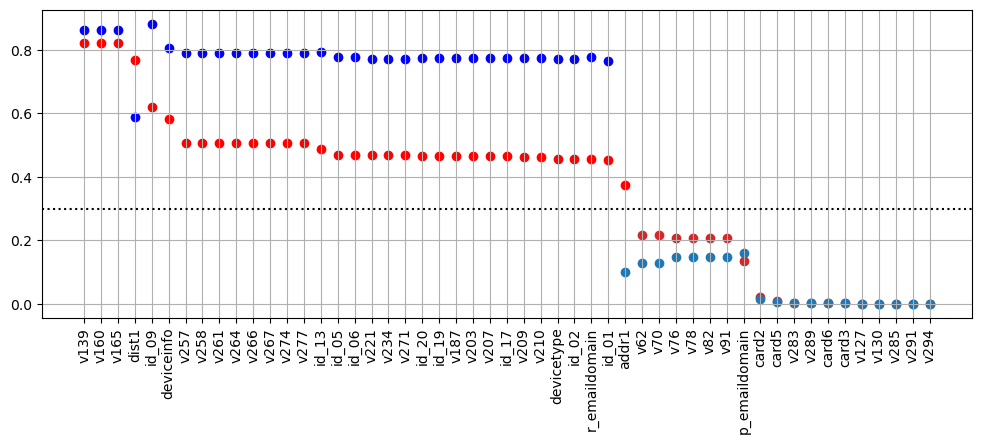

In [67]:
fig, ax = plt.subplots(figsize=(12, 4))

x = frac_missing['feature']
y = frac_missing['fraud_missing']
ax.scatter(x[y>=0.3], y[y>=0.3], color='red')
ax.scatter(x[y<0.3], y[y<0.3], color='tab:red')

x = frac_missing['feature']
y = frac_missing['nonfraud_missing']
ax.scatter(x[y>=0.3], y[y>=0.3], color='blue')
ax.scatter(x[y<0.3], y[y<0.3], color='tab:blue')

ax.axhline(0.3, color='k', ls=':')
ax.tick_params(axis='x', rotation=90)
ax.grid()

Categorical Features - Transaction
ProductCD
card1 - card6
addr1, addr2
P_emaildomain
R_emaildomain
M1 - M9

### Train/Test imputation

In [13]:
def impute_missing(X_train, X_test, impute_vars=None, strategy=None):
    
    #Performing imputation for impute_vars columns with strategy
    imputer = SimpleImputer(strategy=strategy)
    imputer.fit(X_train[impute_vars])
    X_train[impute_vars] = pd.DataFrame(imputer.fit_transform(X_train[impute_vars]), columns=impute_vars, index=X_train.index)
    X_test[impute_vars] = pd.DataFrame(imputer.transform(X_test[impute_vars]), columns=impute_vars, index=X_test.index)
    
    return X_train, X_test

In [ ]:

categorical_features = [f'card{i}' for i in range(1, 7)] + ['productcd', 'addr1', 'addr2', 'p_emaildomain', 'r_emaildomain']

# Keep original dtypes
og_dtype = df.dtypes

# Set category dtypes
df = df.astype({i:'category' for i in categorical_features if i in df.columns})





# Split categorical and numerical variables
X_train_cat, X_test_cat = X_train[cat_vars], X_test[cat_vars]
X_train_num, X_test_num = X_train[num_vars], X_test[num_vars]

#Performing imputation for categorical columns with mode
imputer_cat = SimpleImputer(strategy="most_frequent")
X_train_cat_filled = X_train_cat.copy()
imputer_cat.fit(X_train_cat_filled)
X_train_cat_filled = pd.DataFrame(imputer_cat.transform(X_train_cat_filled), columns=X_train_cat_filled.columns)

#Performing imputation for numerical columns with median
imputer_median = SimpleImputer(strategy="median")
df_filled_median = df_num.copy()
imputer_median.fit(df_filled_median)
df_filled_median = pd.DataFrame(imputer_median.transform(df_filled_median),columns=df_filled_median.columns)

# Combine dataset after imputation
df = pd.concat([df_filled_median, df_filled_cat], axis=1)
df.sort_values('transactionTime', inplace=True)

In [1400]:
%%time
#Performing imputation for numerical columns with median
imputer_median = SimpleImputer(strategy="median")
df_filled_median = df_num.copy()
imputer_median.fit(df_filled_median)
df_filled_median = pd.DataFrame(imputer_median.transform(df_filled_median),columns=df_filled_median.columns)

CPU times: user 982 ms, sys: 163 ms, total: 1.15 s
Wall time: 1.18 s


In [1401]:
%%time
#Performing imputation for categorical columns with mode
imputer_cat = SimpleImputer(strategy="most_frequent")
df_filled_cat = df_cat.copy()
imputer_cat.fit(df_filled_cat)
df_filled_cat = pd.DataFrame(imputer_cat.transform(df_filled_cat),columns=df_filled_cat.columns)

CPU times: user 6.82 s, sys: 409 ms, total: 7.23 s
Wall time: 7.25 s


In [1402]:
# Combine dataset after imputation
df = pd.concat([df_filled_median, df_filled_cat], axis=1)
df.sort_values('transactionTime', inplace=True)

In [1403]:
df.select_dtypes(exclude=np.number).nunique()

transactionTime    573349
week                   27
day                   182
weekday                 7
hour                   24
productcd               5
card1               13553
card2                 500
card3                 114
card5                 119
card6                   4
addr1                 332
p_emaildomain          59
dtype: int64

In [141]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 590540 entries, 0 to 29526
Data columns (total 51 columns):
 #   Column           Non-Null Count   Dtype              
---  ------           --------------   -----              
 0   TransactionID    590540 non-null  float64            
 1   transactionTime  590540 non-null  datetime64[ns, UTC]
 2   month            590540 non-null  int32              
 3   week             590540 non-null  period[W-MON]      
 4   day              590540 non-null  object             
 5   weekday          590540 non-null  category           
 6   hour             590540 non-null  category           
 7   Amount           590540 non-null  float64            
 8   productcd        590540 non-null  object             
 9   card1            590540 non-null  float64            
 10  card2            581607 non-null  float64            
 11  card3            588975 non-null  float64            
 12  card5            586281 non-null  float64            
 13  card6

# Define feature encoding

In [14]:
# --- Predictors

# Numerical variables
numerical_vars = ['Amount', 'c1', 'c2', 'c4', 'c5', 'c6', 'c7',
       'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'v62', 'v70', 'v76',
       'v78', 'v82', 'v91', 'v127', 'v130', 'v283', 'v285', 'v289', 'v291',
       'v294']
# Missingness indicator variables
missing_indicator_vars = [i for i in df.columns if '_missing' in i]
# Frequency encoding variables
freq_enc_vars = ['hour', 'card3', 'card5', 'p_emaildomain']
# Target encoding variables
target_enc_vars = ['card1', 'card2', 'addr1']+missing_indicator_vars
# One-hot encoding variables
onehot_enc_vars = ['weekday', 'card6', 'productcd']

# Categorical variables
cat_vars = list(set(freq_enc_vars+target_enc_vars+onehot_enc_vars+missing_indicator_vars))
# List of all predictors before encoding
var_cols = numerical_vars+cat_vars
# Geographical features for class imbalance oversampling (if used)
geo_vars = []

# Logging configuration
# logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

In [134]:
# --- Predictors

# Dictionary of features
feature_dict={}

# Numerical variables
feature_dict['numerical'] = ['Amount', 'c1', 'c2', 'c4', 'c5', 'c6', 'c7',
       'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'v62', 'v70', 'v76',
       'v78', 'v82', 'v91', 'v127', 'v130', 'v283', 'v285', 'v289', 'v291',
       'v294']

# Missingness indicator variables
feature_dict['missing_indicator'] = [i for i in df.columns if '_missing' in i]

# Frequency encoding variables
feature_dict['freq_enc']= ['hour', 'card3', 'card5', 'p_emaildomain']

# Target encoding variables
feature_dict['target_enc']= ['card1', 'card2', 'addr1']+missing_indicator_vars

# One-hot encoding variables
feature_dict['onehot_enc'] = ['weekday', 'card6', 'productcd']

# Categorical variables
feature_dict['categorical'] = sorted(list(set(freq_enc_vars+target_enc_vars+onehot_enc_vars+missing_indicator_vars)))

# List of all predictors before encoding
feature_dict['all'] = numerical_vars+cat_vars

# Geographical features for class imbalance oversampling (if used)
geo_vars = [] # Not being used

# Checks
if set(feature_dict['numerical']).intersection(feature_dict['categorical']):
    raise ValueError('There is an intersection between numerical and categorical sets.')
if not set(feature_dict['categorical']) == set([k for j in [feature_dict[i] for i in feature_dict if 'enc' in i] for k in j]):
    raise ValueError('Categorical variables do not match with encoding sets.')
enc_sets = [feature_dict[i] for i in feature_dict if 'enc' in i]
if sum([len(set(a).intersection(b)) for i, a in enumerate(enc_sets[:-1]) for b in enc_sets[i+1:]]):
    raise ValueError('There is an intersection among the enconding sets.')

# Logging configuration
# logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Encoding/Scaling

In [15]:
# --- Encoding/Scaling ---

def encode_scale_data(X_train: pd.DataFrame, 
                      X_test: pd.DataFrame, 
                      y_train: pd.Series, 
                      numerical_vars: List[str]=None, 
                      target_enc_vars: List[str]=None, 
                      freq_enc_vars: List[str]=None, 
                      onehot_enc_vars: List[str]=None) -> Tuple[pd.DataFrame, pd.DataFrame]:
    ''' Encode and scale data. '''
    pd.set_option('future.no_silent_downcasting', True)
    
    # Target encoding
    if target_enc_vars:
        target_encoder = TargetEncoder(cols=target_enc_vars)
        X_train = target_encoder.fit_transform(X_train, y_train)
        X_test = target_encoder.transform(X_test)
    
    # Frequency encoding
    if freq_enc_vars:
        freq_encoder = CountEncoder(cols=freq_enc_vars)
        X_train = freq_encoder.fit_transform(X_train, y_train)
        X_test = freq_encoder.transform(X_test)
    
    # Scaling
    if numerical_vars:
        scaler = StandardScaler(with_mean=True, with_std=True).set_output(transform="pandas")
        scale_cols = numerical_vars+freq_enc_vars+target_enc_vars
        scaler.fit(X_train[scale_cols])
        X_train = pd.concat([X_train.drop(scale_cols, axis=1), scaler.transform(X_train[scale_cols])], axis=1)
        X_test = pd.concat([X_test.drop(scale_cols, axis=1), scaler.transform(X_test[scale_cols])], axis=1)
    
    # One-hot encoding
    if onehot_enc_vars:
        onehot_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
        
        # Fit-transform variables
        X_train_onehot = pd.DataFrame(onehot_encoder.fit_transform(X_train[onehot_enc_vars].astype('str')))
        X_train_onehot.columns = onehot_encoder.get_feature_names_out()
        X_train_onehot.index = X_train.index

        X_test_onehot = pd.DataFrame(onehot_encoder.transform(X_test[onehot_enc_vars].astype('str')))
        X_test_onehot.columns = onehot_encoder.get_feature_names_out()
        X_test_onehot.index = X_test.index
        
        # Remove original categorical variables
        X_train.drop(onehot_enc_vars, axis=1, inplace=True)
        X_test.drop(onehot_enc_vars, axis=1, inplace=True)
        
        # Concatenate data set with one-hot columns
        X_train = pd.concat([X_train, X_train_onehot], axis=1)
        X_test = pd.concat([X_test, X_test_onehot], axis=1)


    return X_train, X_test

# Class imbalance

In [16]:
def combine_geography(df, geo_vars=None):
    df = df.copy()
    var_name = '_'.join(geo_vars)
    df.insert(df.columns.get_loc(geo_vars[0]), var_name, df[geo_vars].agg('_'.join, axis=1))
    df.drop(geo_vars, axis=1, inplace=True)
    return df

def split_geography(df, geo_vars=None):
    var_name = '_'.join(geo_vars)
    idx = df.columns.get_loc(var_name)
    df_split = df[var_name].str.split('_', expand=True)
    df_split.columns = geo_vars
    return pd.concat([df.iloc[:, :idx], df_split, df.iloc[:, idx:]], axis=1).drop(var_name, axis=1)

def aux(X, variables=None, p=False):
    for var in variables:
        print(var, X[var].nunique())
        if p:
            print(X[var].unique())

# Class imbalance
def class_imbalance(X_train, y_train, 
                    over_sample=True,
                    over_sample_ratio='auto',
                    under_sample=True, 
                    under_sample_ratio='auto', 
                    geo_vars=None, 
                    cat_vars=None):

    # Undersample
    if under_sample:
        # Random Under Sampler
        undersampler = RandomUnderSampler(sampling_strategy=under_sample_ratio, random_state=1)
        X_train, y_train = undersampler.fit_resample(X_train, y_train)
        
    # Oversample
    if over_sample:
        if geo_vars is None:
            raise ValueError("geo_vars cannot be None")
        if cat_vars is None:
            raise ValueError("geo_vars cannot be None")
        # Combine geographical features
        X_train = combine_geography(X_train, geo_vars=geo_vars)
    
        # SMOTENC
        categorical_features = [v for v in cat_vars if v not in geo_vars]+['_'.join(geo_vars)]
        smotenc = SMOTENC(categorical_features=categorical_features, random_state=1)
        X_train, y_train = smotenc.fit_resample(X_train, y_train)
    
        # Split geographical features
        X_train = split_geography(X_train, geo_vars=geo_vars)

    return X_train, y_train

# main()

In [17]:
%%time
# Split data into Train/Test sets
X, y = df[var_cols], df['isFraud']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

print(f'Class imbalance before: {100*y_train.sum()/len(y_train):.3f}%')

Class imbalance before: 3.514%
CPU times: user 80.8 ms, sys: 42.4 ms, total: 123 ms
Wall time: 123 ms


In [18]:
%%time
# Imputation of missing categorical variables
X_train, X_test  = impute_missing(X_train, X_test, impute_vars=cat_vars, strategy='most_frequent')
# Imputation of missing numerical variables
X_train, X_test  = impute_missing(X_train, X_test, impute_vars=numerical_vars, strategy='median')

CPU times: user 2.75 s, sys: 340 ms, total: 3.09 s
Wall time: 3.09 s


In [19]:
# %%time
# Class imbalance
X_train, y_train = class_imbalance(X_train, y_train, 
                                   under_sample=True,
                                   under_sample_ratio=0.1,#'not minority', 
                                   over_sample=False,
                                   geo_vars=geo_vars,
                                   cat_vars=cat_vars,
                                  )

print(f'Class imbalance after: {100*y_train.sum()/len(y_train):.3f}%')

Class imbalance after: 9.091%


In [20]:
%%time
# Encode and scale data
X_train, X_test = encode_scale_data(X_train, X_test, y_train, 
                                    numerical_vars=numerical_vars, 
                                    target_enc_vars=target_enc_vars, 
                                    freq_enc_vars=freq_enc_vars, 
                                    onehot_enc_vars=onehot_enc_vars)

CPU times: user 1.7 s, sys: 367 ms, total: 2.07 s
Wall time: 2.07 s


# Define models

In [23]:
# Models to be evaluated

logistic = Model(name='LR', 
                 arc=LogisticRegression, 
                 parameters=dict(class_weight='balanced', max_iter=500, random_state=1))

lgbm = Model(name='LGBM', 
             arc=LGBMClassifier,
             parameters=dict(objective='binary', is_unbalance=True, random_state=1, verbose=-1))

mlp = Model(name='MLP', arc=BinaryMLP1L,
            parameters=dict(input_size=X_train.shape[1], 
                            layer1_size=128,
                            learning_rate=1e-3, 
                            max_epochs=100, 
                            verbose=False, 
                            random_state=1))

model_list = [logistic, lgbm, mlp]
# model_list = [logistic, lgbm]
# model_list = [lgbm]
model_names = {'LR':'Logistic Regression', 'LGBM':'LightGBM', 'MLP':'MLP'}

In [22]:
# Class of model for evaluation
ModelType = Union[LogisticRegression, LGBMClassifier, BinaryMLP1L]
class Model:
    def __init__(self, name: str, arc: Type[ModelType], parameters: dict):
        """
        Initializes a model instance.

        Args:
        - name (str): The name of the model (e.g., 'LogisticRegression', 'RandomForest').
        - arc (class): The model class (e.g., LogisticRegression, RandomForestClassifier).
        - parameters (dict): The hyperparameters for the model.
        """
        self.name = name
        self.arc = arc
        self.parameters = parameters
        self.instance = None  # Placeholder for the actual model instance

    def __repr__(self):
            params_str = ", \n\t".join(f"{key} = {value}" for key, value in self.parameters.items())
            return (f"Model name: {self.name}\n"
                    f"{self.arc.__name__}(\n\t"
                    f"{params_str})")
        
    def reset(self):
        """Resets the model by re-instantiating it with the given parameters."""
        self.instance = self.arc(**self.parameters)

    def fit(self, X_train: pd.DataFrame, y_train: pd.Series):
        """Trains the model on the given training data."""
        if self.instance is None:
            self.reset()
        self.instance.fit(X_train, y_train)

    def predict(self, X_test: pd.DataFrame):
        """Generates predictions using the trained model."""
        if self.instance is None:
            raise ValueError("Model has not been trained yet. Call fit() first.")
        return self.instance.predict(X_test)
    
    def predict_proba(self, X_test: pd.DataFrame):
        """Generates predictions using the trained model."""
        if self.instance is None:
            raise ValueError("Model has not been trained yet. Call fit() first.")
        return self.instance.predict_proba(X_test)

    def get_model(self):
        """Returns the actual model instance."""
        return self.instance

    def copy(self):
        """Returns a deep copy of the model instance."""
        return copy.deepcopy(self)


# Train and Evaluate models

In [26]:
%%time
metrics=dict()
for model in model_list:
    print(f'Training {model.name}')
    model.reset()
    model.fit(X_train, y_train)
    metrics[model.name] = evaluate_model(model, X_test, y_test)
    print('Done\n')

Training LR
Done

Training LGBM
Done

Training MLP
Done

CPU times: user 23min 53s, sys: 2min 21s, total: 26min 14s
Wall time: 3min 19s


In [25]:
def evaluate_model(model, X_test, y_test):
    ''' Evaluate the model and return metrics obtained. '''
    
    # Predictions
    # if model[0] == 'mlp':
        # pred, pred_prob = test_mlp(model[1], X_test, y_test)
    # else:
        # pred, pred_prob = model[1].predict(X_test), model[1].predict_proba(X_test)[:, 1]
    pred, pred_prob = model.predict(X_test), model.predict_proba(X_test)[:, 1]
    
    # Metrics
    metrics = {
        'recall_score': recall_score(y_test, pred),
        'precision_score': precision_score(y_test, pred),
        'f1_score': f1_score(y_test, pred),
        'ap_score': average_precision_score(y_test, pred_prob),
        'precision_recall_curve': precision_recall_curve(y_test, pred_prob),
        'roc_auc_score': roc_auc_score(y_test, pred_prob),
        'roc_curve': roc_curve(y_test, pred_prob)
    }

    return metrics

In [395]:
# --- MISSING ---
    # # Cross-validation
    # cross_validation(model, X_train, y_train)

# Accuracy

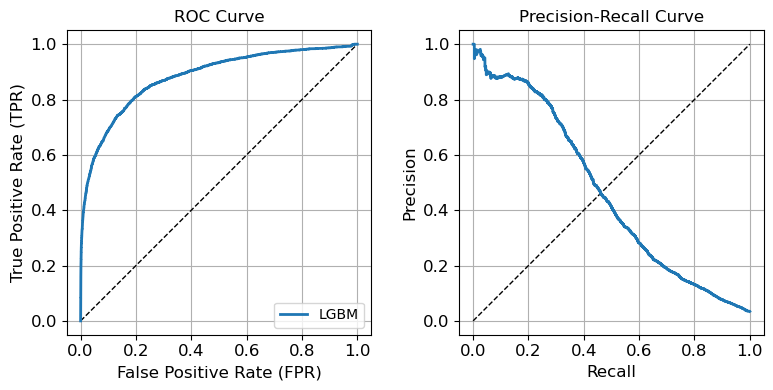

,LGBM
Precision,0.18
Recall,0.71
F1,0.29
Average Precision,0.46
ROC-AUC,0.88


In [207]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))


for i, model in enumerate(model_list):
    m = model.name
    # ROC curve
    plot_roc_curve(metrics[m]['roc_curve'], metrics[m]['roc_auc_score'], model_name=m, color='C'+str(i), ax=ax[0])
    # PR curve
    plot_precision_recall_curve(metrics[m]['precision_recall_curve'], color='C'+str(i), ax=ax[1])

ax[0].set_aspect('equal')
ax[1].set_aspect('equal')

# plt.savefig(fig_folder+'roc_pr_curve.png', dpi=300)
plt.show()

models_metrics=[]
for model in model_list:
    m = model.name
    models_metrics.append([metrics[m]['precision_score'], 
                           metrics[m]['recall_score'], 
                           metrics[m]['f1_score'], 
                           metrics[m]['ap_score'],
                           metrics[m]['roc_auc_score']])

display(pd.DataFrame(models_metrics, columns=['Precision', 'Recall', 'F1', 'Average Precision', 'ROC-AUC'], 
                     index=[m.name for m in model_list]).round(2).T)

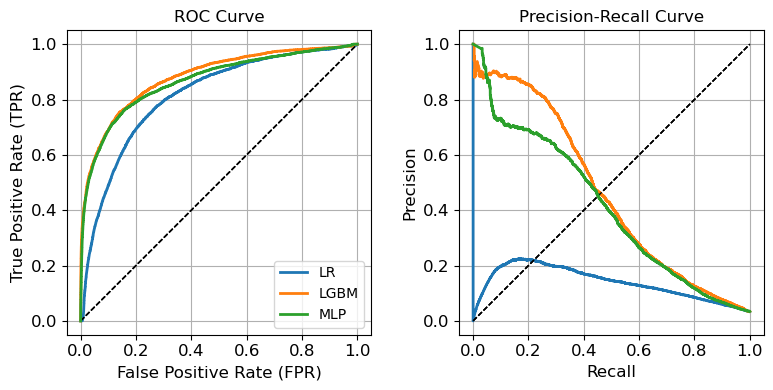

,LR,LGBM,MLP
Precision,0.12,0.18,0.55
Recall,0.63,0.72,0.38
F1,0.21,0.29,0.45
Average Precision,0.14,0.46,0.41
ROC-AUC,0.81,0.88,0.87


In [42]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))


for i, model in enumerate(model_list):
    m = model.name
    # ROC curve
    plot_roc_curve(metrics[m]['roc_curve'], metrics[m]['roc_auc_score'], model_name=m, color='C'+str(i), ax=ax[0])
    # PR curve
    plot_precision_recall_curve(metrics[m]['precision_recall_curve'], color='C'+str(i), ax=ax[1])

ax[0].set_aspect('equal')
ax[1].set_aspect('equal')

# plt.savefig(fig_folder+'roc_pr_curve.png', dpi=300)
plt.show()

models_metrics=[]
for model in model_list:
    m = model.name
    models_metrics.append([metrics[m]['precision_score'], 
                           metrics[m]['recall_score'], 
                           metrics[m]['f1_score'], 
                           metrics[m]['ap_score'],
                           metrics[m]['roc_auc_score']])

display(pd.DataFrame(models_metrics, columns=['Precision', 'Recall', 'F1', 'Average Precision', 'ROC-AUC'], 
                     index=[m.name for m in model_list]).round(2).T)

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

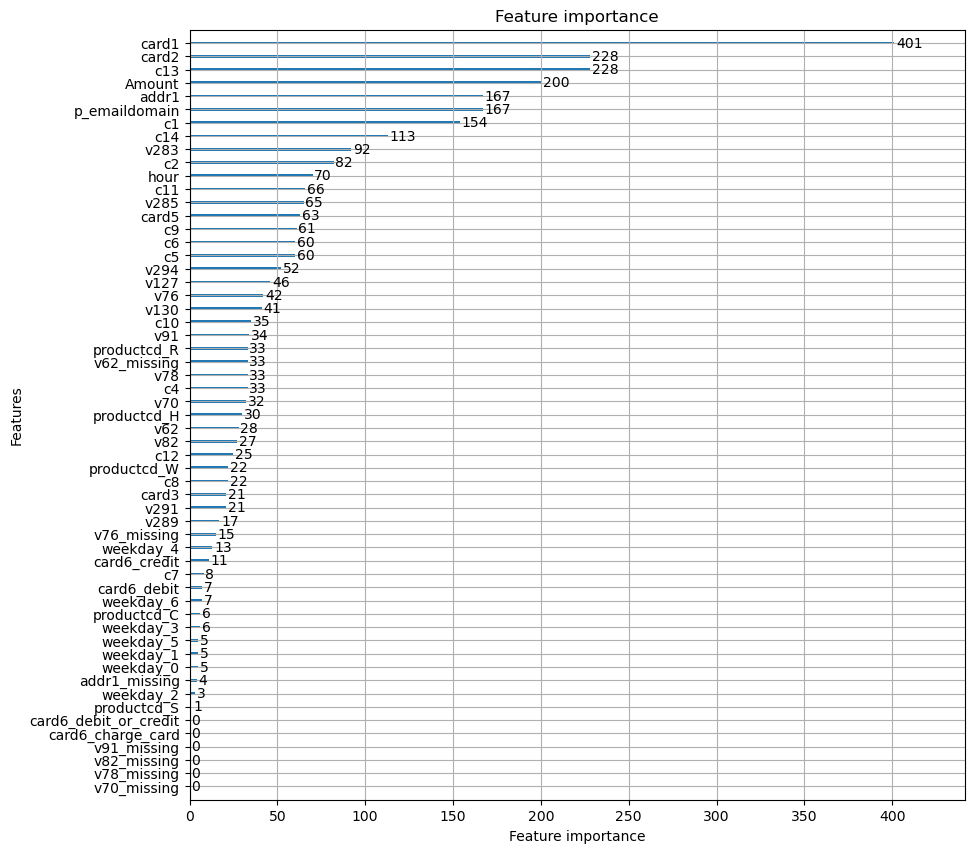

In [43]:
fig, ax = plt.subplots(figsize=(10, 10))

lgb.plot_importance(lgbm.get_model(), ax=ax, ignore_zero=False)


In [27]:
# --- Precision recall curve ---
def plot_precision_recall_curve(model_pr_curve, color='C0', lw=2, ls='-', marker=None, ax=None, 
                                title_fs=12, axis_label_fs=12, axis_tick_fs=12):
    ''' Plot the precision-recall curve.'''
    # Compute the precision, recall and threshold
    precision, recall, thresholds = model_pr_curve
    
    # fig, ax = plt.subplots(figsize=(4.5, 4))
    if ax is None:
        ax = plt.gca()
    
    # Plot the curve
    ax.plot([0, 1], [0, 1], color='k', linestyle='--', lw=1)  # Plot the diagonal line (random classifier)
    ax.plot(recall, precision, color=color, marker=marker, lw=lw, ls=ls)
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel('Recall', fontsize=axis_label_fs)
    ax.set_ylabel('Precision', fontsize=axis_label_fs)
    ax.set_title('Precision-Recall Curve', fontsize=title_fs)
    ax.tick_params(labelsize=axis_tick_fs)
    ax.grid(True)

    plt.tight_layout()
    # plt.show()
    # plt.savefig('precision_recall_curve.png', dpi=500, bbox_inches='tight')

In [28]:
# Plot the ROC curve
def plot_roc_curve(model_roc_curve, model_roc_auc, color='C0', model_name=None, ax=None, 
                   lw=2, ls='-', title_fs=12, axis_label_fs=12, legend_fs=10, axis_tick_fs=12):
    # Compute ROC curve and AUC
    fpr, tpr, thresholds = model_roc_curve
    roc_auc = model_roc_auc

    # fig, ax = plt.subplots(figsize=(4.5, 4))
    if ax is None:
        ax = plt.gca()

    ax.plot([0, 1], [0, 1], color='k', linestyle='--', lw=1)  # Plot the diagonal line (random classifier)
    ax.plot(fpr, tpr, color=color, lw=lw, ls=ls, label=f'{model_name}')# (AUC = {roc_auc:.2f})')
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel('False Positive Rate (FPR)', fontsize=axis_label_fs)
    ax.set_ylabel('True Positive Rate (TPR)', fontsize=axis_label_fs)
    ax.set_title('ROC Curve', fontsize=title_fs)
    ax.legend(loc='lower right', fontsize=legend_fs)
    ax.tick_params(labelsize=axis_tick_fs)
    ax.grid(True)
    # plt.show()


# Certification bounds
Provide informed decisions
- Model Perfomance Metrics
> - Bootstrapping (stratified bootstrapping for keep class imbalance ratio) (Block bootstrap)
> - Wilson Score Interval
> - Conformal Prediction
- Model Predictions
- Stability and Drift
- Adversarial Risk

<font size=5> Bootstrap </font>

In [1551]:
from sklearn.utils import resample

def bootstrap_ci(y_true, y_pred, metric_func, n_bootstrap=100, alpha=0.05):
    scores = []
    for _ in range(n_bootstrap):
        indices = resample(range(len(y_true)), replace=True)
        score = metric_func(np.array(y_true)[indices], np.array(y_pred)[indices])
        scores.append(score)
    
    lower = np.percentile(scores, 100 * (alpha / 2))
    upper = np.percentile(scores, 100 * (1 - alpha / 2))
    return np.mean(scores), lower, upper

In [1530]:
model

Model name: LGBM
LGBMClassifier(
	objective = binary, 
	is_unbalance = True, 
	random_state = 1, 
	verbose = -1)

In [1531]:
pred, pred_prob = model.predict(X_test), model.predict_proba(X_test)[:, 1]

In [1539]:
metrics['LGBM']['recall_score']

0.7477854330708661

In [1552]:
%%time
mean, upper, lower = bootstrap_ci(y_test, pred, recall_score) 

CPU times: user 5.37 s, sys: 90.8 ms, total: 5.46 s
Wall time: 5.46 s


In [1556]:
print(f'Mean={mean:.3f}, Upper = {upper:.3f}, Lower = {lower:.3f}')
print(abs(mean-lower))
print(mean-upper)

Mean=0.747, Upper = 0.736, Lower = 0.759
0.01134055326545269
0.011234143908092187


# STOPPED HERE CI
- wilson score interval


## Train/Test windows

In [868]:
# General temporal features
df.insert(1, 'month_date', df['transactionTime'].dt.to_period('M'))
df.insert(1, 'week_date', df['transactionTime'].dt.to_period('W-MON'))
df.insert(1, 'day_date', df['transactionTime'].dt.to_period('D'))

df.head()

/var/folders/x6/nm550mg94y75s74djxxkq6kw0000gr/T/ipykernel_31551/2368438145.py:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df.insert(1, 'month_date', df['transactionTime'].dt.to_period('M'))
/var/folders/x6/nm550mg94y75s74djxxkq6kw0000gr/T/ipykernel_31551/2368438145.py:3: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df.insert(1, 'week_date', df['transactionTime'].dt.to_period('W-MON'))
/var/folders/x6/nm550mg94y75s74djxxkq6kw0000gr/T/ipykernel_31551/2368438145.py:4: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df.insert(1, 'day_date', df['transactionTime'].dt.to_period('D'))


,TransactionID,day_date,week_date,month_date,month,Amount,c1,c2,c4,c5,...,weekday,hour,productcd,card1,card2,card3,card5,card6,addr1,p_emaildomain
0,2987000.0,2021-01-02,2020-12-29/2021-01-04,2021-01,1.0,68.5,1.0,1.0,0.0,0.0,...,5,0,W,13926.0,321.0,150.0,142.0,credit,315.0,gmail.com
1,2987001.0,2021-01-02,2020-12-29/2021-01-04,2021-01,1.0,29.0,1.0,1.0,0.0,0.0,...,5,0,W,2755.0,404.0,150.0,102.0,credit,325.0,gmail.com
2,2987002.0,2021-01-02,2020-12-29/2021-01-04,2021-01,1.0,59.0,1.0,1.0,0.0,0.0,...,5,0,W,4663.0,490.0,150.0,166.0,debit,330.0,outlook.com
3,2987003.0,2021-01-02,2020-12-29/2021-01-04,2021-01,1.0,50.0,2.0,5.0,0.0,0.0,...,5,0,W,18132.0,567.0,150.0,117.0,debit,476.0,yahoo.com
4,2987004.0,2021-01-02,2020-12-29/2021-01-04,2021-01,1.0,50.0,1.0,1.0,0.0,0.0,...,5,0,H,4497.0,514.0,150.0,102.0,credit,420.0,gmail.com


### Protocols

In [869]:
def generate_retrain_lookback_epochs(df: pd.DataFrame, 
                                     period: str=None,
                                     L_tw: int=None,
                                     R_tw: int=None,
                                    ) -> dict[int, dict[str, pd.arrays.PeriodArray]]:
    """ 
        Parameters:
        df (pd.DataFrame): Dataframe of the transactions.
        period (str): Column with the calendar period (D, W, M, Y) to compute the epochs.
        R_tw (int): Retrain time window length.
        L_tw (int): Lookback time window lenght.
    """
    epoch={}

    # Beginning and ending of the dataset
    T0 = df[period].min()
    Tf = df[period].max()

    # First training time
    t0 = T0 + L_tw

    # Number of retrain epochs
    N = int(np.ceil((Tf - t0).n / R_tw))

    for n in range(N):
        t = t0 + n * R_tw
        train_start = t - L_tw
        train_end = t - 1
        test_start = t
        test_end = min(t + (R_tw  - 1), Tf)

        epoch[n] = {}
        epoch[n]['train_start'] = train_start
        epoch[n]['train_end'] = train_end
        epoch[n]['test_start'] = test_start
        epoch[n]['test_end'] = test_end
    
    return epoch

In [870]:
def epoch_train_test_split(df: pd.DataFrame, 
                           period: str, 
                           epoch: Dict[str, pd.arrays.PeriodArray], 
                           var_cols: List[str], 
                           target_var: str,
                          ) -> Tuple[pd.DataFrame, pd.DataFrame, pd.Series, pd.Series]:
    """Splits dataset into train and test sets for a given epoch."""
    
    # Train set
    train_start = epoch['train_start']
    train_end = epoch['train_end']
    df_train = df.loc[(df[period]>=train_start)&(df[period]<=train_end)]
    X_train = df_train[var_cols]
    y_train = df_train[target_var]
    
    # Test set
    test_start = epoch['test_start']
    test_end = epoch['test_end']
    df_test = df.loc[(df[period]>=test_start)&(df[period]<=test_end)]
    X_test = df_test[var_cols]
    y_test = df_test[target_var]

    return X_train, X_test, y_train, y_test

In [871]:
def global_eval_tw(df: pd.DataFrame, 
                   period: str=None,
                   tw: int=None, 
                   L_tw: int=None, 
                   R_tw: int=None, 
                   model: Model=None,
                   target_var: str=None,
                   numerical_vars: list[str]=None,
                   target_enc_vars: list[str]=None, 
                   freq_enc_vars: list[str]=None, 
                   onehot_enc_vars: list[str]=None,
                   geo_vars: list[str]=None,
                   under_sample: bool=True,
                   under_sample_ratio: Union[float, str] = 'auto',
                   over_sample: bool=False,
                   over_sample_ratio: Union[float, str] = 'auto',
                  ) -> Tuple[Dict[str, float], int]:
    """Evaluates model performance over retrain and lookback time windows."""

    # All Features
    var_cols = numerical_vars + freq_enc_vars + target_enc_vars + onehot_enc_vars
    # Categorical features
    cat_vars = freq_enc_vars + target_enc_vars + onehot_enc_vars
    
    # Define epochs for retraining and lookback
    epoch = generate_retrain_lookback_epochs(df, period=period, L_tw=L_tw, R_tw=R_tw)

    # Model predictions
    pred = []

    # Concatenation of all test sets for each epoch
    global_y_test = []

    # Log of the skipped epochs due to no fraud cases
    skipped_epochs=0
    
    # Evaluate epochs
    for e in epoch:

        # Reset model before training for the current time window
        model.reset()
        
        # Split Train/Test sets
        X_train, X_test, y_train, y_test = epoch_train_test_split(df, period, epoch[e], var_cols, target_var)

        # Skip epochs with no fraud cases in test or train
        if (y_train.sum() == 0) or (y_test.sum() == 0):
            skipped_epochs += 1
            continue
    
        # Class imbalance
        X_train, y_train = class_imbalance(X_train, y_train, 
                                           under_sample=under_sample,
                                           under_sample_ratio=under_sample_ratio, 
                                           over_sample=over_sample,
                                           over_sample_ratio=over_sample_ratio,
                                           geo_vars=geo_vars,
                                           cat_vars=cat_vars
                                          )
        
        # Encode and scale data
        X_train, X_test = encode_scale_data(X_train, X_test, y_train, 
                                            numerical_vars, target_enc_vars, 
                                            freq_enc_vars, onehot_enc_vars)


        # Train model
        # model_trained = model_training(X_train, y_train, model)
        model.fit(X_train, y_train)

        # Model predictions
        pred.append(model.predict(X_test))

        # Global test set
        global_y_test.append(y_test)
    
    # Concatenate results
    # print(pred)
    pred = np.concatenate(pred)
    y_test = pd.concat(global_y_test)
    # print(f'len(pred) = {len(pred)}')
    # print(f'len(pred) = {len(pred)}')

    # Compute metrics
    metrics = {
        'recall': recall_score(y_test, pred),
        'precision': precision_score(y_test, pred),
        'f1': f1_score(y_test, pred),
    }
    
    return metrics, skipped_epochs

In [872]:
def retrain_lookback_matrix(df: pd.DataFrame, 
                            tw_min: int=1, 
                            tw_max: int=None, 
                            options: Dict=None) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """Generates a ndarray of evaluation metrics over paris of different retraining and lookback windows."""

    if tw_max is None:
        raise ValueError('Variable tw_max must be assigned an int value.')

    # Compute metrics for each pair of retrain and lookback time window
    N = tw_max - tw_min + 1
    score_matrix = dict(recall=np.zeros((N, N)), precision=np.zeros((N, N)), f1=np.zeros((N, N)))
    skipped_epochs = 0
    for L in range(tw_min, tw_max + 1):
        for R in range(tw_min, tw_max + 1):
            # Compute metrics for each pair (Retrain, Lookback)
            metrics, se = global_eval_tw(df, L_tw=L, R_tw=R, **options)
            skipped_epochs += se
            i, j = L-tw_min, R-tw_min
            score_matrix['recall'][i, j] = metrics['recall']
            score_matrix['precision'][i, j] = metrics['precision']
            score_matrix['f1'][i, j] = metrics['f1']
        
    print(f'Skipped Epochs: {skipped_epochs}')
    return score_matrix


### Evaluate

In [939]:
# Define parameters of evaluation
tw_min = 1
tw_max = 24
eval_options = dict(
    period='week_date',
    target_var = 'isFraud',
    numerical_vars = numerical_vars,
    target_enc_vars = target_enc_vars,
    freq_enc_vars = freq_enc_vars,
    onehot_enc_vars = onehot_enc_vars,
    geo_vars = geo_vars,
    under_sample=True,
    under_sample_ratio = 0.1,
    over_sample=False,
)

In [940]:
%%time
eval_options['model'] = lgbm
lgbm_rl_matrix = retrain_lookback_matrix(df, tw_min=tw_min, tw_max=tw_max, options=eval_options)

Skipped Epochs: 0
CPU times: user 1h 38min 58s, sys: 1h 49min 41s, total: 3h 28min 39s
Wall time: 37min 1s


In [946]:
# Save result
with open(RESULT_PATH+"ieee_lgbm_rl_matrix.pkl", "wb") as f:
    pickle.dump(lgbm_rl_matrix, f)

In [29]:
# Load results
with open(RESULTS_PATH+"ieee_gbm_rl_matrix.pkl", "rb") as f:
    lgbm_rl_matrix = pickle.load(f)

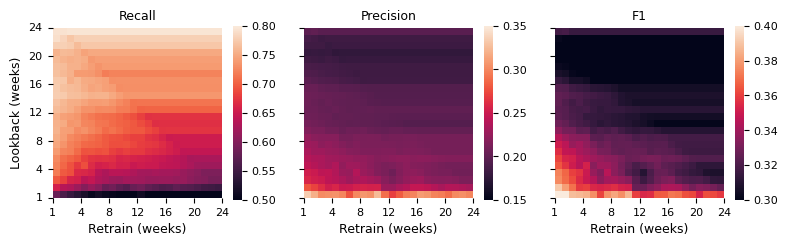

In [1216]:
def plot_rl_matrix(rl_matrix: np.ndarray, tw_min, tw_max, col: int=None, cbar=True, cbar_fs=None):
    

    # Recall
    hm=sns.heatmap(rl_matrix['recall'][::-1], vmin=0.5, vmax=0.8, cbar=cbar,
                xticklabels=np.arange(tw_min, tw_max+1), yticklabels=np.arange(tw_min, tw_max+1)[::-1], 
                ax=ax[0])
    cbar = hm.collections[0].colorbar
    cbar.ax.tick_params(labelsize=cbar_fs)
    
    # Precision
    hm=sns.heatmap(rl_matrix['precision'][::-1], vmin=0.15, vmax=0.35, cbar=cbar,
                xticklabels=np.arange(tw_min, tw_max+1), yticklabels=np.arange(tw_min, tw_max+1)[::-1], 
                ax=ax[1])
    cbar = hm.collections[0].colorbar
    cbar.ax.tick_params(labelsize=cbar_fs)
    
    # F1
    hm=sns.heatmap(rl_matrix['f1'][::-1], vmin=0.3, vmax=0.4, cbar=cbar,
                xticklabels=np.arange(tw_min, tw_max+1), yticklabels=np.arange(tw_min, tw_max+1)[::-1], 
                ax=ax[2])
    cbar = hm.collections[0].colorbar
    cbar.ax.tick_params(labelsize=cbar_fs)


fig, ax = plt.subplots(1, 3, figsize=(8, 2.4), sharex=True, sharey=True)
axis_label_fs = 9
axis_tick_fs = 8
legend_fs = 8
title_fs = 9

# LGBM
plot_rl_matrix(lgbm_rl_matrix, tw_min=tw_min, tw_max=tw_max, cbar=True, cbar_fs=axis_tick_fs)



# Formatting
ax[0].set_title('Recall', loc='center', fontsize=title_fs)
ax[0].set_ylabel('Lookback (weeks)', fontsize=axis_label_fs)
ax[0].set_xticklabels(ax[0].get_xticklabels()[::-1], rotation=0, fontsize=axis_tick_fs)
ax[0].set_xticks(np.concatenate([[0], np.arange(4, 25, 4)]), np.concatenate([[1], np.arange(4, 25, 4)]))
ax[0].set_yticklabels(ax[0].get_yticklabels(), rotation=0, fontsize=axis_tick_fs)
ax[0].set_yticks(np.concatenate([[0], np.arange(4, 25, 4)]), np.concatenate([[1], np.arange(4, 25, 4)])[::-1])

ax[1].set_title('Precision', loc='center', fontsize=title_fs)
ax[1].set_xticklabels(ax[0].get_xticklabels()[::-1], rotation=0, fontsize=axis_tick_fs)
ax[1].set_xticks(np.concatenate([[0], np.arange(4, 25, 4)]), np.concatenate([[1], np.arange(4, 25, 4)]))
ax[1].set_yticklabels(ax[0].get_yticklabels(), rotation=0, fontsize=axis_tick_fs)
ax[1].set_yticks(np.concatenate([[0], np.arange(4, 25, 4)]), np.concatenate([[1], np.arange(4, 25, 4)])[::-1])

ax[2].set_title('F1', loc='center', fontsize=title_fs)
ax[2].set_xticklabels(ax[0].get_xticklabels()[::-1], rotation=0, fontsize=axis_tick_fs)
ax[2].set_xticks(np.concatenate([[0], np.arange(4, 25, 4)]), np.concatenate([[1], np.arange(4, 25, 4)]))
ax[2].set_yticklabels(ax[0].get_yticklabels(), rotation=0, fontsize=axis_tick_fs)
ax[2].set_yticks(np.concatenate([[0], np.arange(4, 25, 4)]), np.concatenate([[1], np.arange(4, 25, 4)])[::-1])

ax[0].set_xlabel('Retrain (weeks)', fontsize=axis_label_fs)
ax[1].set_xlabel('Retrain (weeks)', fontsize=axis_label_fs)
ax[2].set_xlabel('Retrain (weeks)', fontsize=axis_label_fs)

for a in ax.flat:
    a.set_aspect('equal')

plt.subplots_adjust(wspace=0.01)
plt.tight_layout()
plt.show()

# Sensitivity Analysis

### SHAP - LightGBM

In [165]:
# %%time
# shap_values={}
# explainer={}
# for m in model_list[1:2]:
#     print(m)
#     if (m.name == 'mlp') or (m.name == 'MLP'):
#         pass
#         # # Create SHAP Explainer for model
#         # X_train_kmeans = shap.kmeans(X_train, 100) # Summarize train set with k mean samples
#         # explainer = shap.KernelExplainer(model[m].predict, X_train_kmeans)
#         # # Calculate SHAP values
#         # shap_values[m] = explainer(X_test)
#     else:
#         # Create SHAP Explainer for model
#         explainer[m.name] = shap.Explainer(m.get_model(), X_train)
#         # Calculate SHAP values
#         shap_values[m.name] = explainer[m.name](X_test)
        
#     print('ok')

In [29]:
%%time
explainer={}
shap_values={}
for model in model_list[:2]:
    print(model)
    # Create SHAP Explainer for model
    explainer[model.name] = shap.Explainer(model.get_model(), X_train)
    # Calculate SHAP values
    shap_values[model.name] = explainer[model.name](X_test)

Model name: LR
LogisticRegression(
	class_weight = balanced, 
	max_iter = 500, 
	random_state = 1)
Model name: LGBM
LGBMClassifier(
	objective = binary, 
	is_unbalance = True, 
	random_state = 1, 
	verbose = -1)


100%|===================| 118018/118108 [04:52<00:00]        

CPU times: user 4min 51s, sys: 1.56 s, total: 4min 53s
Wall time: 4min 53s


In [370]:
%%time
# === Single model SHAP values === 
yes = False
if yes:
    model = logistic
    print(model)
    # Create SHAP Explainer for model
    model_explainer = shap.Explainer(model.get_model(), X_train)
    # Calculate SHAP values
    model_shap_values = model_explainer[model.name](X_test)

Model name: LR
LogisticRegression(
	class_weight = balanced, 
	max_iter = 500, 
	random_state = 1)
CPU times: user 1.29 s, sys: 130 ms, total: 1.42 s
Wall time: 1.43 s


In [377]:
def get_top_features(model, n_top=3)
top_features={}
for model in model_list[:2]:
    print(model.name)
    # Get the absolute mean SHAP values for each feature
    shap_importance = np.abs(shap_values[model.name].values).mean(axis=0)
    
    # Create a DataFrame for better readability
    feature_importance_df = pd.DataFrame({
        'feature': X_train.columns,  # Feature names
        'shap_importance': shap_importance
    })
    
    # Sort by importance and select the top 3 features
    top_features[model.name] = feature_importance_df.sort_values(by='shap_importance', ascending=False).head(3)
    
    display(top_3_features)

LR


,feature,shap_importance
13,c14,1.572944
8,c9,0.753341
10,c11,0.700976


LGBM


,feature,shap_importance
31,card1,0.902601
12,c13,0.549987
1,c1,0.328815


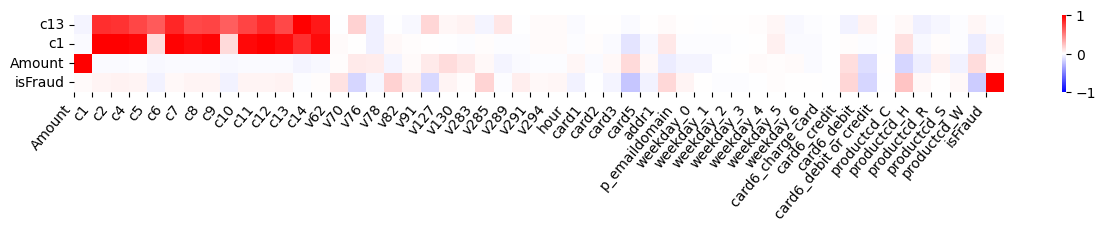

In [1519]:
fig, ax = plt.subplots(figsize=(15, 1))

sns.heatmap(corr_matrix.loc[top_3_features['feature'].to_list()+['isFraud'], :], vmin=-1, cmap='bwr', ax=ax)
ax.tick_params(axis='y', rotation=0)
ax.set_xticks(np.arange(corr_matrix.index.shape[0]), corr_matrix.index, rotation=50, ha='right')

plt.show()

In [55]:
features

NameError: name 'features' is not defined

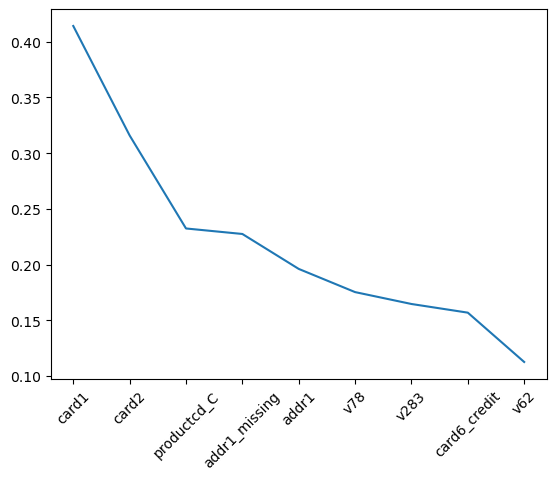

In [54]:
fig, ax = plt.subplots()
corr_matrix.loc[:, 'isFraud'].sort_values(ascending=False)[1:10].plot(ax=ax)

ax.tick_params(axis='x', rotation=45)

<Axes: >

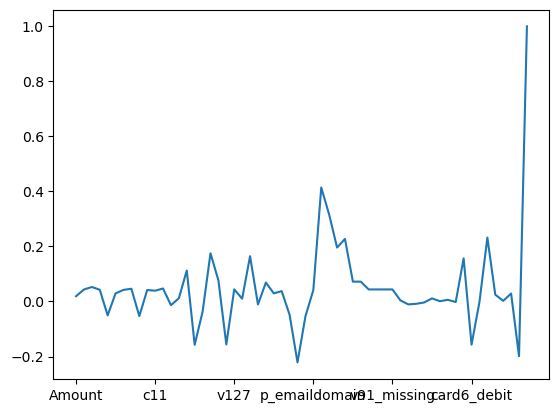

In [45]:
corr_matrix.loc[:, 'isFraud'].plot()

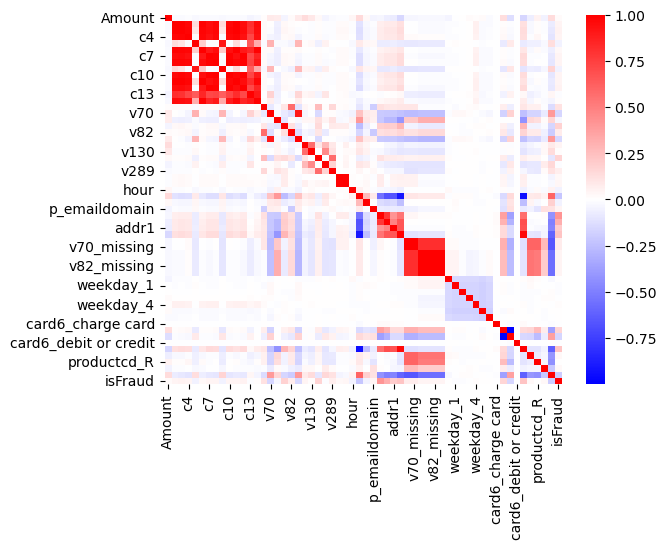

In [44]:
# Correlation of the high-importance features
corr_matrix  = pd.concat([X_train, y_train], axis=1).corr()

fig, ax = plt.subplots()

sns.heatmap(corr_matrix, cmap='bwr')

plt.show()

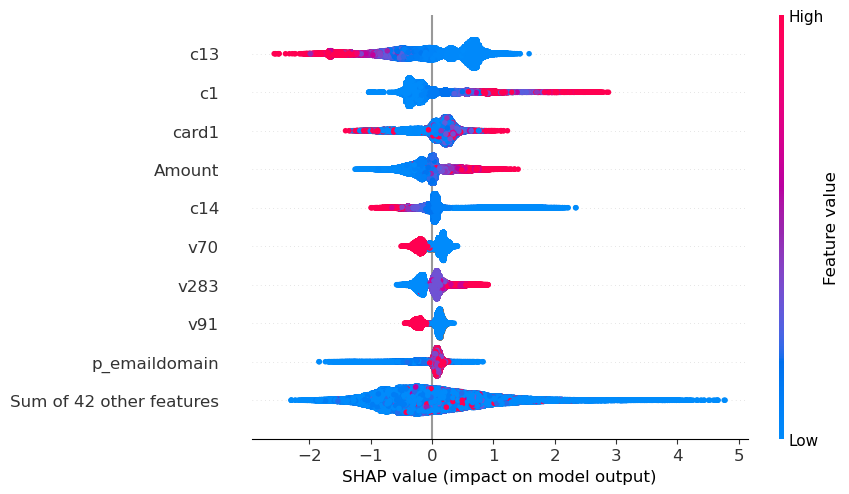

In [168]:
plt.figure(figsize=(20, 8))

shap.plots.beeswarm(shap_values, show=False)
# plt.title(title[i]+m.name, loc='left', fontsize=10)
plt.tick_params(axis='both', labelsize=12)
plt.gca().xaxis.label.set_size(12)
# plt.subplots_adjust(hspace=0.4)
# plt.savefig(fig_folder+'shap_values.png', dpi=300, bbox_inches='tight')
plt.show()

In [379]:
shap_values.keys()

dict_keys(['LR', 'LGBM'])

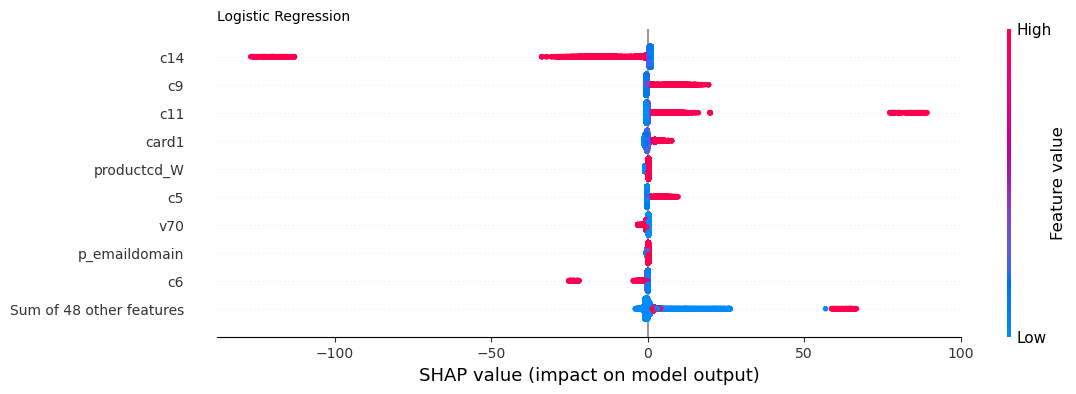

In [38]:
model = logistic

fig, ax = plt.subplots(figsize=(12, 4))

shap.plots.beeswarm(shap_values[model.name], show=False, ax=ax, plot_size=None)
ax.set_title(model_names[model.name], loc='left', fontsize=10)
ax.tick_params(axis='both', labelsize=10)

# plt.savefig(fig_folder+f'shap_values_{model.name}.png', dpi=300, bbox_inches='tight')
plt.show()

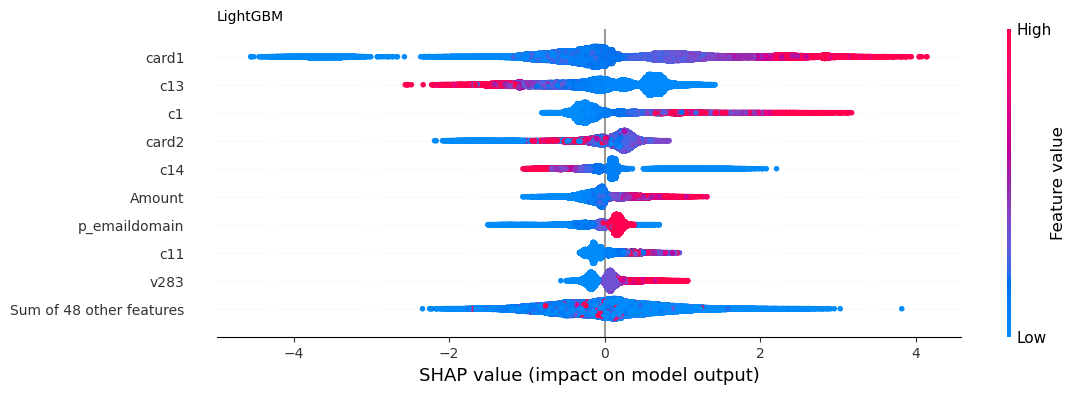

In [39]:
model = lgbm

fig, ax = plt.subplots(figsize=(12, 4))

shap.plots.beeswarm(shap_values[model.name], show=False, ax=ax, plot_size=None)
ax.set_title(model_names[model.name], loc='left', fontsize=10)
ax.tick_params(axis='both', labelsize=10)

# plt.savefig(fig_folder+f'shap_values_{model.name}.png', dpi=300, bbox_inches='tight')
plt.show()

LGBM


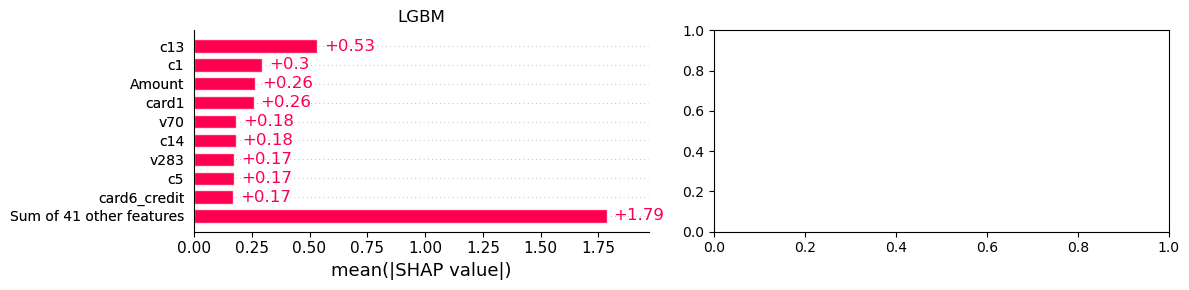

In [325]:
fig, ax = plt.subplots(1, 2, figsize=(12, 3))

# plt.figure()
for i, m in enumerate(model_list[1:2]):
    if m.name == 'mlp':
        pass
    else:
        print(m.name)
        # plt.subplot(1, 2, i+1)
        shap.plots.bar(shap_values[m.name], ax=ax[i], show=False)
        # plt.xlabel_format(fontsize=10)
        ax[i].set_title(m.name)
        ax[i].tick_params(axis='y', which='major', labelsize=10)
plt.tight_layout()
plt.show()

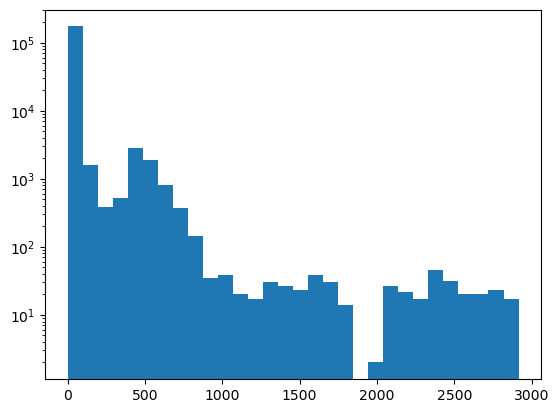

In [395]:
fig, ax = plt.subplots()

v = X_train.c13
ax.hist(v, bins=30)
ax.set_yscale('log')
# ax.set_xscale('log')

plt.show()

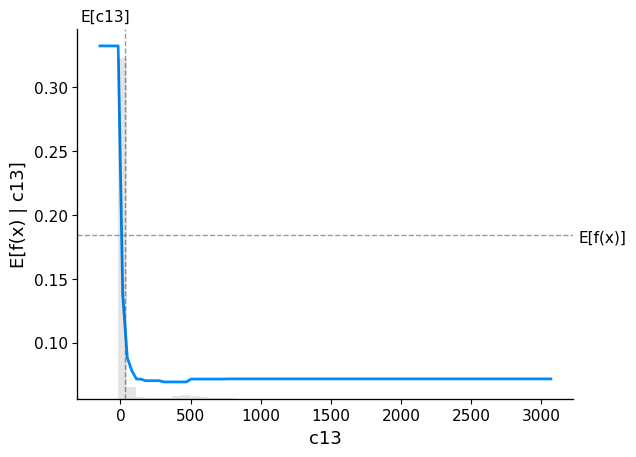

In [327]:
# make a standard partial dependence plot with a single SHAP value overlaid
fig, ax = shap.partial_dependence_plot(
    'c13',
    lgbm.predict,
    X_train,
    model_expected_value=True,
    feature_expected_value=True,
    show=False,
    ice=False,
)

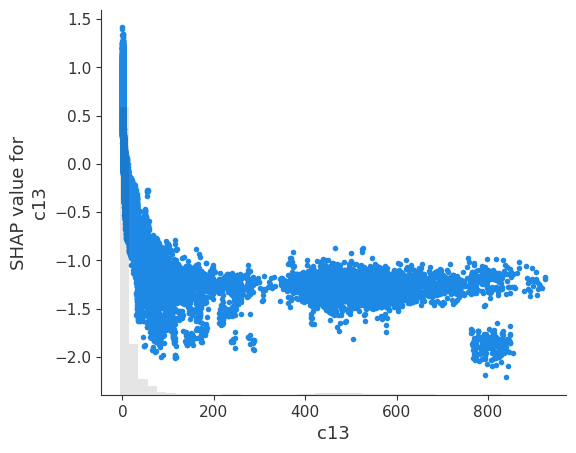

In [328]:
shap.plots.scatter(shap_values['LGBM'][:, 'c13'])

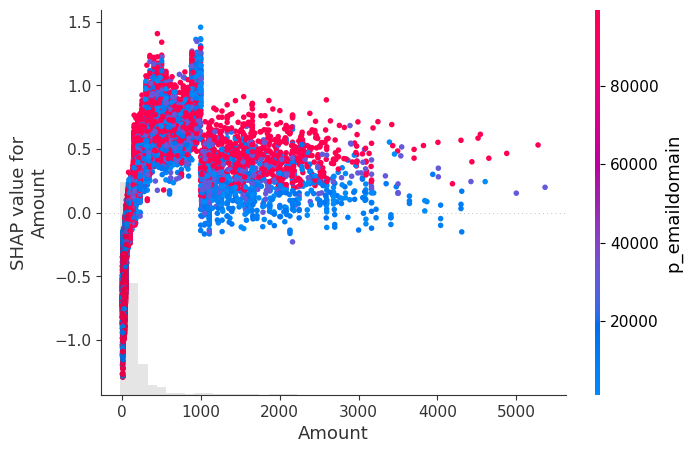

In [354]:
shap.plots.scatter(shap_values['LGBM'][:, 'Amount'], color=shap_values['LGBM'])

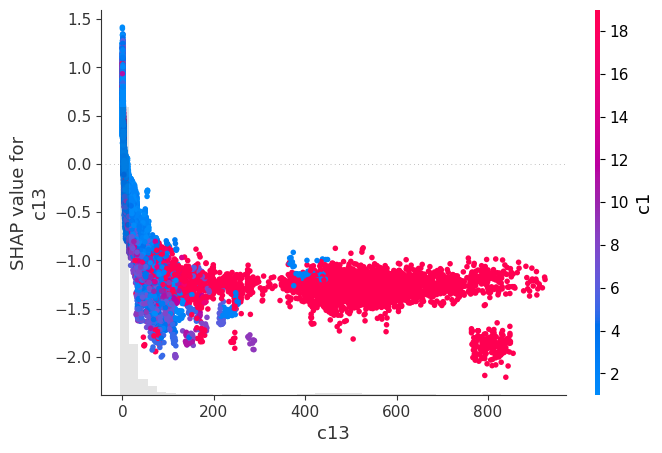

In [509]:
shap.plots.scatter(shap_values['LGBM'][:, 'c13'], color=shap_values['LGBM'])

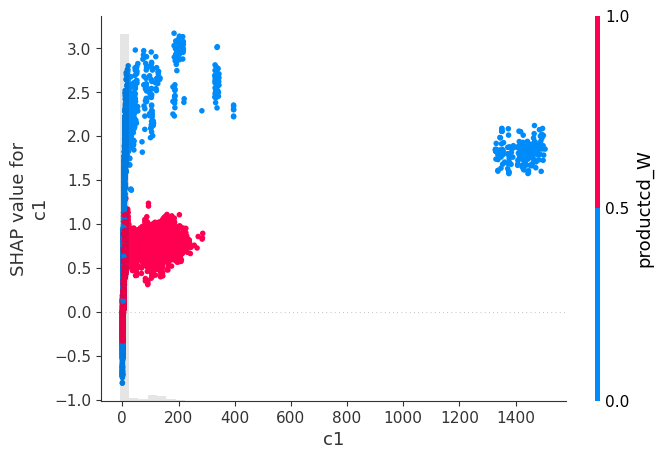

In [510]:
shap.plots.scatter(shap_values['LGBM'][:, 'c1'], color=shap_values['LGBM'])

<font size=4> Summary Statistics </font>

In [573]:
pd.concat([df.loc[df.isFraud == 1]['c13'].describe().rename('c13 fraud'), 
           df.loc[df.isFraud == 0]['c13'].describe().rename('c13 non-fraud'),
           df.loc[df.isFraud == 1]['c1'].describe().rename('c1 fraud'), 
           df.loc[df.isFraud == 0]['c1'].describe().rename('c1 non-fraud'),
           df.loc[df.isFraud == 1]['Amount'].describe().rename('Amount fraud'), 
           df.loc[df.isFraud == 0]['Amount'].describe().rename('Amount non-fraud'),
          ], axis=1).iloc[1:]

,c13 fraud,c13 non-fraud,c1 fraud,c1 non-fraud,Amount fraud,Amount non-fraud
mean,24.967768,32.814474,35.53574,13.314952,149.244779,134.511665
std,165.979050,127.832166,242.97626,127.787969,232.212163,239.395077
min,0.000000,0.000000,0.00000,0.000000,0.292000,0.251000
25%,1.000000,1.000000,1.00000,1.000000,35.044000,43.970000
50%,1.000000,3.000000,2.00000,1.000000,75.000000,68.500000
75%,6.000000,13.000000,6.00000,3.000000,161.000000,120.000000
max,2915.000000,2918.000000,4682.00000,4685.000000,5191.000000,31937.390000


<font size=4>Distribution</font>

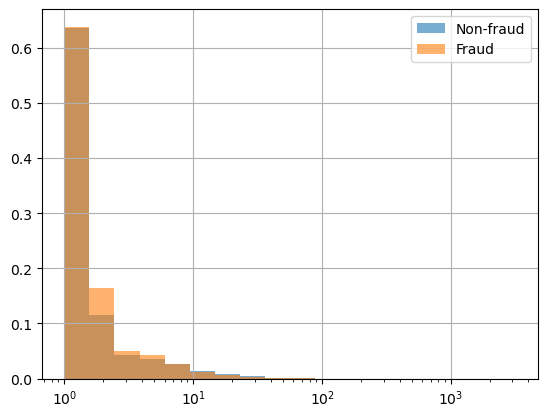

In [1247]:
fig, ax = plt.subplots()

df.loc[(df.isFraud == 0)]['c13'].hist(bins=np.logspace(0, 3.5, 19), ax=ax, label='Non-fraud', density=True, alpha=0.6, color='C0')
df.loc[(df.isFraud == 1)]['c13'].hist(bins=np.logspace(0, 3.5, 19), ax=ax, label='Fraud', density=True, alpha=0.6, color='C1')

ax.set_xscale('log')
# ax.set_yscale('log')
ax.legend()

plt.show()

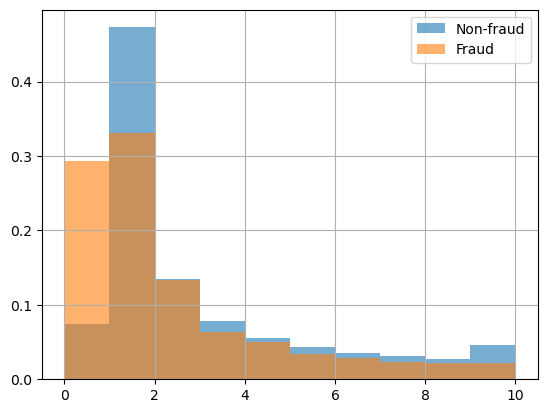

In [1248]:
fig, ax = plt.subplots()

df.loc[(df.isFraud == 0)&(df['c13']<=10)]['c13'].hist(bins=10, ax=ax, label='Non-fraud', density=True, alpha=0.6, color='C0')
df.loc[(df.isFraud == 1)&(df['c13']<=10)]['c13'].hist(bins=10, ax=ax, label='Fraud', density=True, alpha=0.6, color='C1')

# ax.set_xscale('log')
# ax.set_yscale('log')
ax.legend()

plt.show()

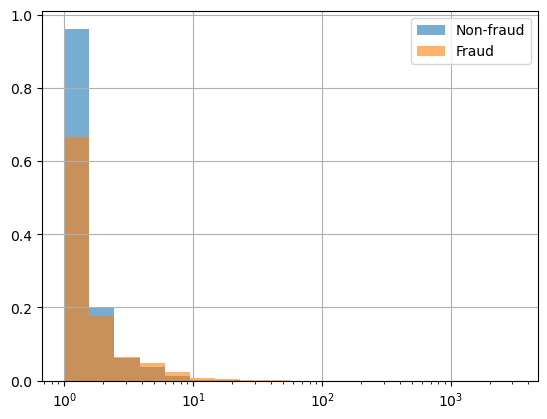

In [1249]:
fig, ax = plt.subplots()

df.loc[(df.isFraud == 0)]['c1'].hist(bins=np.logspace(0, 3.5, 19), ax=ax, label='Non-fraud', density=True, alpha=0.6, color='C0')
df.loc[(df.isFraud == 1)]['c1'].hist(bins=np.logspace(0, 3.5, 19), ax=ax, label='Fraud', density=True, alpha=0.6, color='C1')

ax.set_xscale('log')
# ax.set_yscale('log')

ax.legend()

plt.show()

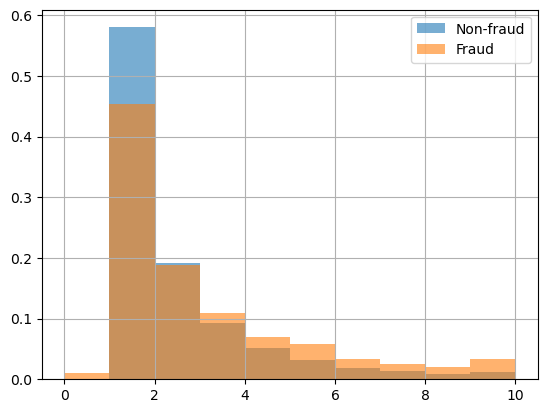

In [1257]:
fig, ax = plt.subplots()

df.loc[(df.isFraud == 0)&(df['c1']<=10)]['c1'].hist(bins=10, ax=ax, label='Non-fraud', density=True, alpha=0.6, color='C0')
df.loc[(df.isFraud == 1)&(df['c1']<=10)]['c1'].hist(bins=10, ax=ax, label='Fraud', density=True, alpha=0.6, color='C1')
# ax.axvline(x=df.loc[(df.isFraud == 0)&(df['c1']<=10)]['c1'].mean(), color='C0', ls='--', lw=2)
# ax.axvline(x=df.loc[(df.isFraud == 1)&(df['c1']<=10)]['c1'].mean(), color='C1', ls='--', lw=2)

# ax.set_xscale('log')
# ax.set_yscale('log')

ax.legend()

plt.show()

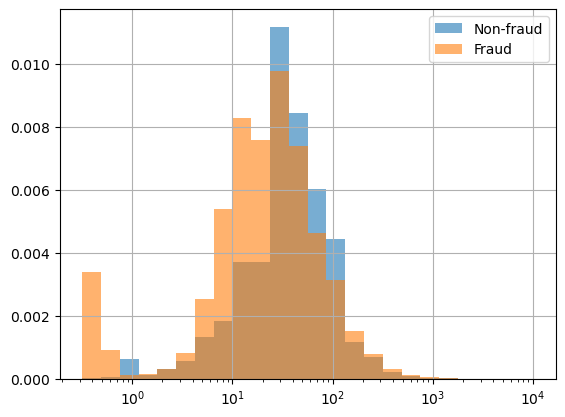

In [650]:
fig, ax = plt.subplots()
df.loc[(df.isFraud == 0)]['Amount'].hist(bins=np.logspace(-0.5, 4, 25), ax=ax, label='Non-fraud', density=True, alpha=0.6)
df.loc[(df.isFraud == 1)]['Amount'].hist(bins=np.logspace(-0.5, 4, 25), ax=ax, label='Fraud', density=True, alpha=0.6)
ax.set_xscale('log')
# ax.set_yscale('log')
ax.legend()

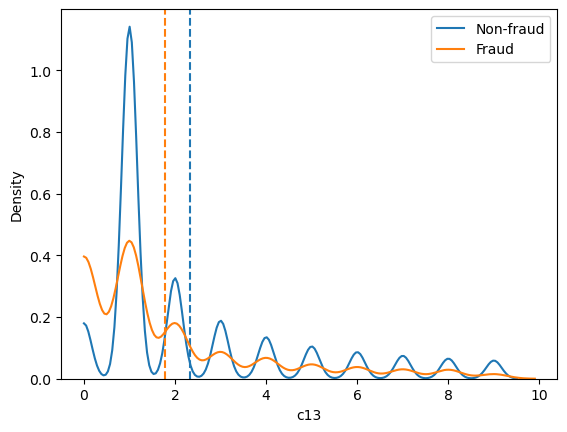

In [566]:
fig, ax = plt.subplots()

feature = 'c13'

# Non-fraud
data = df.loc[df.isFraud == 0]
data = data.loc[data[feature] < 10]
sns.kdeplot(data=data, x=feature, log_scale=[False, False], clip=(0, 10), label='Non-fraud', ax=ax)
ax.axvline(x=data[feature].mean(), color='tab:blue', ls='--')


# Fraud
data = df.loc[df.isFraud == 1]
data = data.loc[data[feature] < 10]
sns.kdeplot(data=data, x=feature, log_scale=[False, False], clip=(0, 10), label='Fraud', ax=ax)
ax.axvline(x=data[feature].mean(), color='tab:orange', ls='--')


ax.legend()

plt.show()

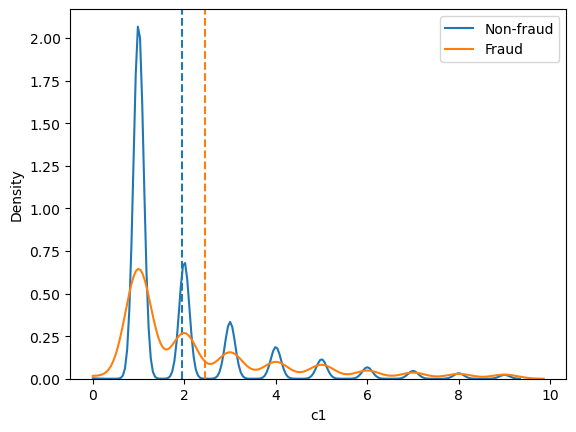

In [1244]:
fig, ax = plt.subplots()

feature = 'c1'

# Non-fraud
data = df.loc[df.isFraud == 0]
data = data.loc[data[feature] < 10]
sns.kdeplot(data=data, x=feature, log_scale=[False, False], clip=(0, 10), label='Non-fraud', ax=ax)
ax.axvline(x=data[feature].mean(), color='tab:blue', ls='--')


# Fraud
data = df.loc[df.isFraud == 1]
data = data.loc[data[feature] < 10]
sns.kdeplot(data=data, x=feature, log_scale=[False, False], clip=(0, 10), label='Fraud', ax=ax)
ax.axvline(x=data[feature].mean(), color='tab:orange', ls='--')

# ax.set_ylim(bottom=1e-8, top=5e-2)
# ax.set_yscale('log')


ax.legend()

plt.show()

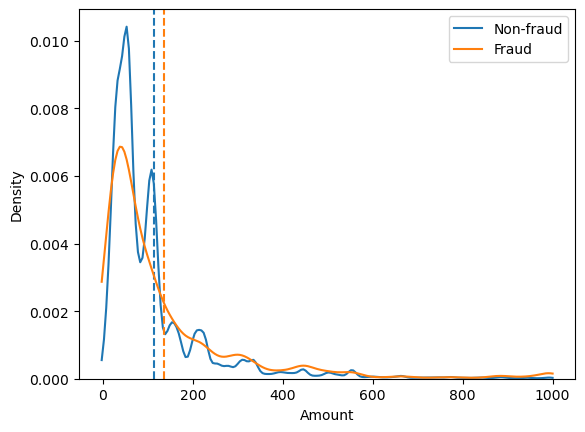

In [690]:
fig, ax = plt.subplots()

feature = 'Amount'

# Non-fraud
data = df.loc[df.isFraud == 0]
data = data.loc[data[feature] < 1000]
sns.kdeplot(data=data, x=feature, log_scale=[False, False], clip=(-3, 1000), label='Non-fraud', ax=ax)
ax.axvline(x=data[feature].mean(), color='tab:blue', ls='--')


# Fraud
data = df.loc[df.isFraud == 1]
data = data.loc[data[feature] < 1000]
sns.kdeplot(data=data, x=feature, log_scale=[False, False], clip=(-3, 1000), label='Fraud', ax=ax)
ax.axvline(x=data[feature].mean(), color='tab:orange', ls='--')

# ax.set_ylim(bottom=1e-8, top=5e-2)
# ax.set_yscale('log')


ax.legend()

plt.show()

<font size=4> Moving Average of Daily Average </font>

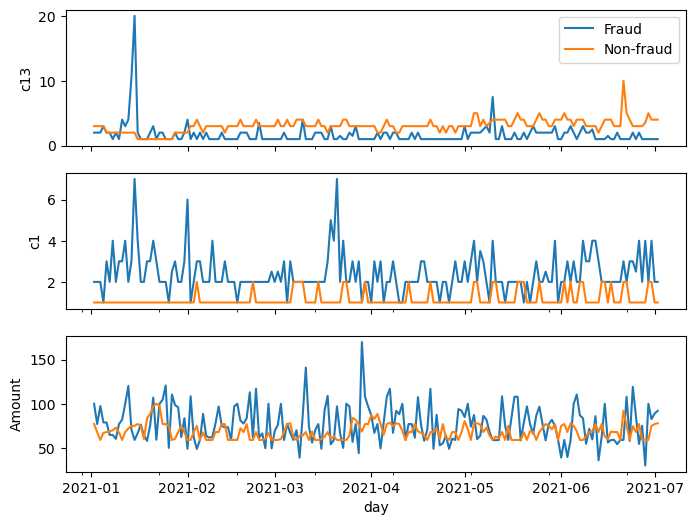

In [1380]:
fig, ax = plt.subplots(3, 1, figsize=(8, 6), sharex=True)

feature = 'c13'

df.loc[df.isFraud==1].groupby('day')[feature].median().plot(label='Fraud', ax=ax[0])
df.loc[df.isFraud==0].groupby('day')[feature].median().plot(label='Non-fraud', ax=ax[0])
# df.loc[df.isFraud==1].groupby('day')[feature].median().rolling(window=1).mean().plot(label='Fraud', ax=ax[0])
# df.loc[df.isFraud==0].groupby('day')[feature].median().rolling(window=1).mean().plot(label='Non-fraud', ax=ax[0])

feature = 'c1'
df.loc[df.isFraud==1].groupby('day')[feature].median().plot(label='Fraud', ax=ax[1])
df.loc[df.isFraud==0].groupby('day')[feature].median().plot(label='Non-fraud', ax=ax[1])
# df.loc[df.isFraud==1].groupby('day')[feature].median().rolling(window=1).mean().plot(label='Fraud', ax=ax[1])
# df.loc[df.isFraud==0].groupby('day')[feature].median().rolling(window=1).mean().plot(label='Non-fraud', ax=ax[1])

feature = 'Amount'
df.loc[df.isFraud==1].groupby('day')[feature].median().plot(label='Fraud', ax=ax[2])
df.loc[df.isFraud==0].groupby('day')[feature].median().plot(label='Non-fraud', ax=ax[2])
# df.loc[df.isFraud==1].groupby('day')[feature].median().rolling(window=1).mean().plot(label='Fraud', ax=ax[2])
# df.loc[df.isFraud==0].groupby('day')[feature].median().rolling(window=1).mean().plot(label='Non-fraud', ax=ax[2])

ax[0].legend()
ax[0].set_xlabel('')
# ax[0].set_yscale('log')
ax[0].set_ylabel('c13')
ax[0].set_ylim(bottom=0)

ax[1].set_xlabel('')
# ax[1].set_yscale('log')
ax[1].set_ylabel('c1')

ax[2].set_ylabel('Amount')

plt.show()

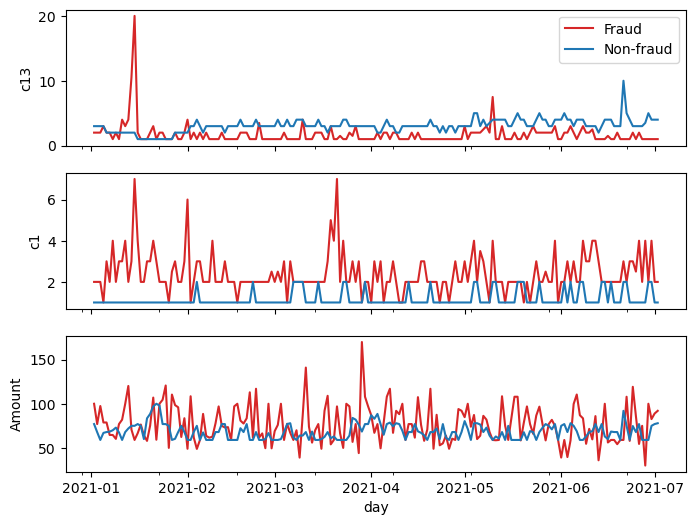

In [1259]:
fig, ax = plt.subplots(3, 1, figsize=(8, 6), sharex=True)

feature = 'c13'
df.loc[df.isFraud==1].groupby('day')[feature].median().rolling(window=1).mean().plot(label='Fraud', ax=ax[0], c='C3')
df.loc[df.isFraud==0].groupby('day')[feature].median().rolling(window=1).mean().plot(label='Non-fraud', ax=ax[0], c='C0')
# Modify train
# dftrain = df.loc[X_train.index]
# dftrain[feature] = dftrain[feature] + 2
# dftrain.loc[dftrain.isFraud == 1].groupby('day')[feature].median().rolling(window=1).mean().plot(label='Modified', ax=ax[0], 
                                                                                                 # ls='--', c='k')

feature = 'c1'
df.loc[df.isFraud==1].groupby('day')[feature].median().rolling(window=1).mean().plot(label='Fraud', ax=ax[1], c='C3')
df.loc[df.isFraud==0].groupby('day')[feature].median().rolling(window=1).mean().plot(label='Non-fraud', ax=ax[1], c='C0')

# Modify train
# dftrain = df.loc[X_train.index]
# dftrain.loc[dftrain[feature] >= 2, feature] -= 1
# dftrain.loc[dftrain.isFraud == 1].groupby('day')[feature].median().rolling(window=1).mean().plot(label='Modified', ax=ax[1], 
                                                                                                 # ls='--', c='k')

feature = 'Amount'
df.loc[df.isFraud==1].groupby('day')[feature].median().rolling(window=1).mean().plot(label='Fraud', ax=ax[2], c='C3')
df.loc[df.isFraud==0].groupby('day')[feature].median().rolling(window=1).mean().plot(label='Non-fraud', ax=ax[2], c='C0')

ax[0].legend()
ax[0].set_xlabel('')
# ax[0].set_yscale('log')
ax[0].set_ylabel('c13')
ax[0].set_ylim(bottom=0)

ax[1].set_xlabel('')
# ax[1].set_yscale('log')
ax[1].set_ylabel('c1')

ax[2].set_ylabel('Amount')

plt.show()

In [1]:
fig, ax = plt.subplots(3, 1, figsize=(8, 6), sharex=True)

feature = 'c13'
df.loc[df.isFraud==1].groupby('day')[feature].median().rolling(window=1).mean().plot(label='Fraud', ax=ax[0], c='C3')
df.loc[df.isFraud==0].groupby('day')[feature].median().rolling(window=1).mean().plot(label='Non-fraud', ax=ax[0], c='C0')
# Modify train
# dftrain = df.loc[X_train.index]
# dftrain[feature] = dftrain[feature] + 2
# dftrain.loc[dftrain.isFraud == 1].groupby('day')[feature].median().rolling(window=1).mean().plot(label='Modified', ax=ax[0], 
                                                                                                 # ls='--', c='k')

feature = 'c1'
df.loc[df.isFraud==1].groupby('day')[feature].median().rolling(window=1).mean().plot(label='Fraud', ax=ax[1], c='C3')
df.loc[df.isFraud==0].groupby('day')[feature].median().rolling(window=1).mean().plot(label='Non-fraud', ax=ax[1], c='C0')

# Modify train
# dftrain = df.loc[X_train.index]
# dftrain.loc[dftrain[feature] >= 2, feature] -= 1
# dftrain.loc[dftrain.isFraud == 1].groupby('day')[feature].median().rolling(window=1).mean().plot(label='Modified', ax=ax[1], 
                                                                                                 # ls='--', c='k')

feature = 'Amount'
df.loc[df.isFraud==1].groupby('day')[feature].median().rolling(window=1).mean().plot(label='Fraud', ax=ax[2], c='C3')
df.loc[df.isFraud==0].groupby('day')[feature].median().rolling(window=1).mean().plot(label='Non-fraud', ax=ax[2], c='C0')

ax[0].legend()
ax[0].set_xlabel('')
# ax[0].set_yscale('log')
ax[0].set_ylabel('c13')
ax[0].set_ylim(bottom=0)

ax[1].set_xlabel('')
# ax[1].set_yscale('log')
ax[1].set_ylabel('c1')

ax[2].set_ylabel('Amount')

plt.show()

NameError: name 'plt' is not defined

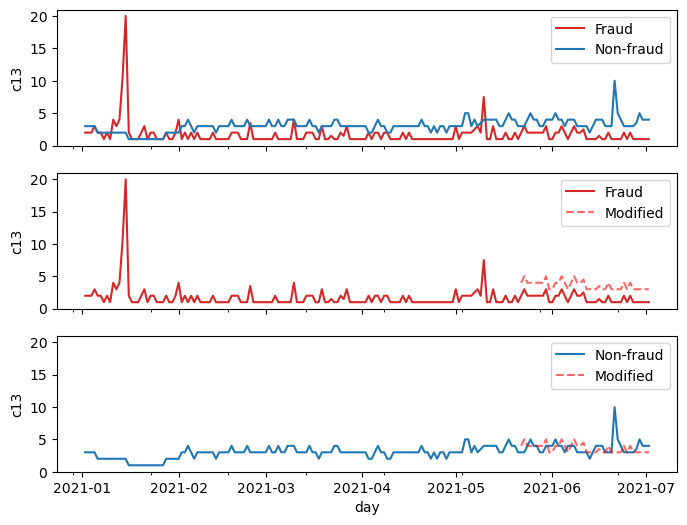

In [1586]:
fig, ax = plt.subplots(3, 1, figsize=(8, 6), sharex=True)

feature = 'c13'

df.loc[df.isFraud==1].groupby('day')[feature].median().rolling(window=1).mean().plot(label='Fraud', ax=ax[0], c='C3')
df.loc[df.isFraud==0].groupby('day')[feature].median().rolling(window=1).mean().plot(label='Non-fraud', ax=ax[0], c='C0')

df.loc[df.isFraud==1].groupby('day')[feature].median().rolling(window=1).mean().plot(label='Fraud', ax=ax[1], c='C3')
# Test shift
dftest = df.loc[X_test.index]
dftest[feature] = dftest[feature] + 2
dftest.loc[dftest.isFraud == 1].groupby('day')[feature].median().rolling(window=1).mean().plot(label='Modified', ax=ax[1], 
                                                                                                 ls='--', c='red', alpha=0.6)
ax[0].set_ylabel('c13')
ax[0].legend()
ax[0].set_yticks(np.arange(0, 21, 5))
ax[1].legend()
ax[1].set_ylabel('c13')
ax[1].set_ylim(bottom=0, top=21)
ax[1].set_ylabel('c13')
ax[1].set_yticks(np.arange(0, 21, 5))


df.loc[df.isFraud==0].groupby('day')[feature].median().rolling(window=1).mean().plot(label='Non-fraud', ax=ax[2], c='C0')
# Test shift
dftest = df.loc[X_test.index]
dftest[feature] = dftest[feature] + 2
dftest.loc[dftest.isFraud == 1].groupby('day')[feature].median().rolling(window=1).mean().plot(label='Modified', ax=ax[2], 
                                                                                                 ls='--', c='red', alpha=0.6)


ax[2].legend()
ax[2].set_ylabel('c13')
ax[2].set_ylim(bottom=0, top=21)
ax[2].set_ylabel('c13')
ax[2].set_yticks(np.arange(0, 21, 5))

plt.show()

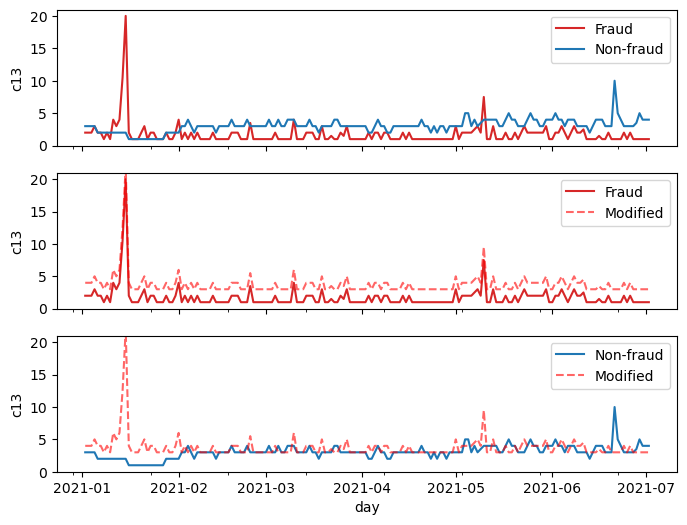

In [1635]:
fig, ax = plt.subplots(3, 1, figsize=(8, 6), sharex=True)

feature = 'c13'

df.loc[df.isFraud==1].groupby('day')[feature].median().rolling(window=1).mean().plot(label='Fraud', ax=ax[0], c='C3')
df.loc[df.isFraud==0].groupby('day')[feature].median().rolling(window=1).mean().plot(label='Non-fraud', ax=ax[0], c='C0')

df.loc[df.isFraud==1].groupby('day')[feature].median().rolling(window=1).mean().plot(label='Fraud', ax=ax[1], c='C3')
# All shift
dftest = df.loc[df.isFraud == 1].copy()
dftest[feature] = dftest[feature] + 2
dftest.loc[dftest.isFraud == 1].groupby('day')[feature].median().rolling(window=1).mean().plot(label='Modified', ax=ax[1], 
                                                                                                 ls='--', c='red', alpha=0.6)
ax[0].set_ylabel('c13')
ax[0].legend()
ax[0].set_yticks(np.arange(0, 21, 5))
ax[1].legend()
ax[1].set_ylabel('c13')
ax[1].set_ylim(bottom=0, top=21)
ax[1].set_ylabel('c13')
ax[1].set_yticks(np.arange(0, 21, 5))


df.loc[df.isFraud==0].groupby('day')[feature].median().rolling(window=1).mean().plot(label='Non-fraud', ax=ax[2], c='C0')
# All shift
dftest = df.loc[df.isFraud == 1].copy()
dftest[feature] = dftest[feature] + 2
dftest.loc[dftest.isFraud == 1].groupby('day')[feature].median().rolling(window=1).mean().plot(label='Modified', ax=ax[2], 
                                                                                                 ls='--', c='red', alpha=0.6)
ax[2].legend()
ax[2].set_ylabel('c13')
ax[2].set_ylim(bottom=0, top=21)
ax[2].set_ylabel('c13')
ax[2].set_yticks(np.arange(0, 21, 5))

plt.show()

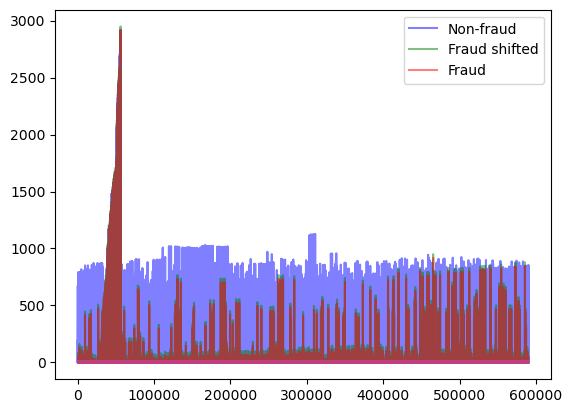

In [1687]:
df.loc[df.isFraud == 0, 'c13'].plot(color='blue', alpha=0.5, label='Non-fraud')


shift_c13 = df.loc[df.isFraud == 1, 'c13'].copy()
shift_c13 += df.loc[df.isFraud == 0, 'c13'].mean()
shift_c13.plot(color='green', alpha=0.5, label='Fraud shifted')

df.loc[df.isFraud == 1, 'c13'].plot(color='red', alpha=0.5, label='Fraud')

plt.legend()

## Counterfactual

- Analyze Average Precision (AP)

In [1353]:
feature = 'c1'
# Modify train
X_train_shift = X_train.copy()
X_train_shift.loc[((X_train_shift[feature] >= 2) & (y_train == 1)), feature] -= 1

In [1303]:
feature = 'Amount'
# Modify train
X_train_shift = X_train.copy()

fraud_median = df.loc[df.isFraud==1][feature].median()
nonfraud_median = df.loc[df.isFraud==0][feature].median()
delta = fraud_median - nonfraud_median

fraud_daily_median_std = df.loc[df.isFraud==1].groupby('day')[feature].median().std()
nonfraud_daily_median_std = df.loc[df.isFraud==0].groupby('day')[feature].median().std()
scale_factor = nonfraud_daily_median_std / fraud_daily_median_std

X_train_shift.loc[(y_train == 1), feature] = ((X_train_shift.loc[(y_train == 1), feature])*2*scale_factor)

In [1706]:
print('Fraud c13\n')
print('Train')
print(X_train[y_train==1]['c13'].median())
print(X_train[y_train==1]['c13'].mean())
print(X_train[y_train==1]['c13'].std())
print('Test')
print(X_test[y_test==1]['c13'].median())
print(X_test[y_test==1]['c13'].mean())
print(X_test[y_test==1]['c13'].std())
print('All')
print(df.loc[df.isFraud==1]['c13'].median())
print(df.loc[df.isFraud==1]['c13'].mean())
print(df.loc[df.isFraud==1]['c13'].std())

print('\nNon-Fraud c13\n')
print('Train')
print(X_train[y_train==0]['c13'].median())
print(X_train[y_train==0]['c13'].mean())
print(X_train[y_train==0]['c13'].std())
print('Test')
print(X_test[y_test==0]['c13'].median())
print(X_test[y_test==0]['c13'].mean())
print(X_test[y_test==0]['c13'].std())
print('All')
print(df.loc[df.isFraud==0]['c13'].median())
print(df.loc[df.isFraud==0]['c13'].mean())
print(df.loc[df.isFraud==0]['c13'].std())

Fraud c13

Train
1.0
26.515753961081995
180.06691959216218
Test
1.0
18.64517716535433
87.12459830720937
All
1.0
24.967768475052026
165.979049991277

Non-Fraud c13

Train
2.0
32.988306524489424
133.57516962026614
Test
4.0
32.31756164287468
106.0952110818806
All
3.0
32.81447400052994
127.83216563661921


In [1564]:
feature = 'c13'
# Shift train and test sets

X_train_shift = X_train.copy()
X_train_shift.loc[y_train == 1, feature] += 
X_test_shift = X_test.copy()
X_test_shift.loc[y_test == 1, feature] += 2

In [1721]:
stats = X_train[y_train==0][feature].describe()
stats

count    165990.000000
mean         32.988307
std         133.575170
min           0.000000
25%           1.000000
50%           2.000000
75%          12.000000
max        2914.000000
Name: c13, dtype: float64

In [1727]:
stats['50%']

2.0

In [1734]:
feature_name = 'c13'
feature = X_train[feature_name]
nonfraud_feature = X_train[y_train==0][feature_name]
feature_stats = {'mean': nonfraud_feature.mean(), 'median': nonfraud_feature.median()}



{'mean': 32.988306524489424, 'median': 2.0}

In [1801]:
%%time

feature_name = 'c13'
feature = X_train[feature_name]
nonfraud_feature = X_train[y_train==0][feature_name]
feature_stats = {'mean': nonfraud_feature.mean(), 'median': nonfraud_feature.median()}
model = lgbm
metrics_shift=dict()

for measure, value in feature_stats.items():

    print(f'Evaluate a {measure} shift on feature {feature_name} of model {model.name}.')
    X_test_shift = X_test.copy()
    fraud_feature = X_test[y_test == 1][feature_name]
    
    # Shift test set + min(max(feature), measure)
    X_test_shift.loc[y_test == 1, feature_name] = (fraud_feature + value).clip(upper=max(feature))
    metrics_shift[f'{model.name}_{feature_name}_+_{measure}'] = evaluate_model(model, X_test_shift, y_test)
    # Shift test set  measure
    X_test_shift.loc[y_test == 1, feature_name] = (fraud_feature - value).clip(lower=min(feature))
    metrics_shift[f'{model.name}_{feature_name}_-_{measure}'] = evaluate_model(model, X_test_shift, y_test)

Evaluate a mean shift on feature c13 of model LGBM.
Evaluate a median shift on feature c13 of model LGBM.
CPU times: user 9.23 s, sys: 6.08 s, total: 15.3 s
Wall time: 1.87 s


In [1802]:
metrics_shift.keys()

dict_keys(['LGBM_c13_+_mean', 'LGBM_c13_-_mean', 'LGBM_c13_+_median', 'LGBM_c13_-_median'])

In [1807]:
k = list(metrics_shift.keys())[0]
k.split('_')

['LGBM', 'c13', '+', 'mean']

# STOPPED HERE

- Identify temporal trends (historical evidence)
- Temporal feature importance
- Write ms
- Implement synthetic fraud transaction generator to shift distributions

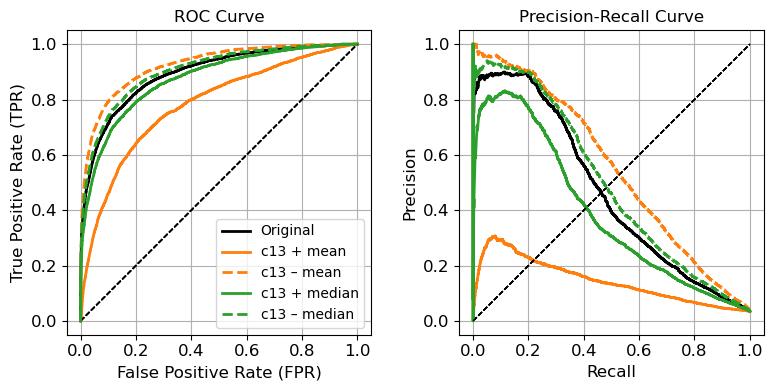

,Original,c13_+_mean,c13_-_mean,c13_+_median,c13_-_median
Precision,0.18,0.13,0.19,0.17,0.18
Recall,0.75,0.52,0.82,0.71,0.77
AP,0.29,0.21,0.31,0.27,0.29
F1,0.47,0.14,0.55,0.39,0.50
ROC-AUC,0.89,0.78,0.92,0.87,0.91


Text(0.5, 0.98, 'LGBM')

In [1817]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))

# Metrics dataframe
model_metrics=[]


# Original Model
model = lgbm
# ROC curve
plot_roc_curve(metrics[model.name]['roc_curve'], metrics[model.name]['roc_auc_score'], model_name='Original', color='k', ax=ax[0])
# PR curve
plot_precision_recall_curve(metrics[model.name]['precision_recall_curve'], color='k', ax=ax[1])

model_metrics.append([metrics[model.name]['precision_score'], 
                      metrics[model.name]['recall_score'], 
                      metrics[model.name]['f1_score'], 
                      metrics[model.name]['ap_score'], 
                      metrics[model.name]['roc_auc_score']])
table_index = ['Original']

# Shifted model

for i, measure in enumerate(feature_stats.keys()):

    
    kplus = f'{model.name}_{feature_name}_+_{measure}'
    kminus = f'{model.name}_{feature_name}_-_{measure}'
        
    # ROC curve
    plot_roc_curve(metrics_shift[kplus]['roc_curve'], metrics_shift[kplus]['roc_auc_score'], 
                   model_name=f'{feature_name} + {measure}', color=f'C{i+1}', ls='-', ax=ax[0])
    plot_roc_curve(metrics_shift[kminus]['roc_curve'], metrics_shift[kminus]['roc_auc_score'], 
                   model_name=f'{feature_name} – {measure}', color=f'C{i+1}', ls='--', ax=ax[0])
    # PR curve
    plot_precision_recall_curve(metrics_shift[kplus]['precision_recall_curve'], color=f'C{i+1}', ls='-', ax=ax[1])
    plot_precision_recall_curve(metrics_shift[kminus]['precision_recall_curve'], color=f'C{i+1}', ls='--', ax=ax[1])

    # Table
    model_metrics.append([metrics_shift[kplus]['precision_score'], 
                          metrics_shift[kplus]['recall_score'], 
                          metrics_shift[kplus]['f1_score'], 
                          metrics_shift[kplus]['ap_score'], 
                          metrics_shift[kplus]['roc_auc_score']])
    table_index.append(f'{feature_name}_+_{measure}')
    model_metrics.append([metrics_shift[kminus]['precision_score'], 
                          metrics_shift[kminus]['recall_score'], 
                          metrics_shift[kminus]['f1_score'], 
                          metrics_shift[kminus]['ap_score'], 
                          metrics_shift[kminus]['roc_auc_score']])
    table_index.append(f'{feature_name}_-_{measure}')



ax[0].set_aspect('equal')
ax[1].set_aspect('equal')

# plt.savefig(fig_folder+'roc_pr_curve.png', dpi=300)
plt.show()

display(pd.DataFrame(model_metrics, columns=['Precision', 'Recall', 'AP', 'F1', 'ROC-AUC'], 
                     index=table_index).round(2).T)
fig.suptitle(model.name)

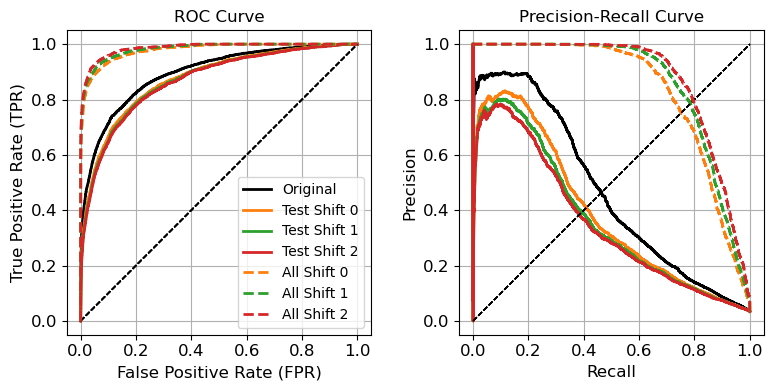

,Original,Test Shift 0,Test Shift 1,Test Shift 2,All Shift 0,All Shift 1,All Shift 2
Precision,0.18,0.17,0.17,0.17,0.44,0.46,0.50
Recall,0.75,0.71,0.70,0.69,0.88,0.89,0.90
AP,0.29,0.27,0.27,0.27,0.59,0.61,0.64
F1,0.47,0.39,0.36,0.35,0.84,0.86,0.88
ROC-AUC,0.89,0.87,0.87,0.87,0.98,0.98,0.99


In [1719]:
# fig, ax = plt.subplots(1, 2, figsize=(8, 4))

# # Metrics dataframe
# model_metrics=[]


# # Original Model
# m = lgbm
# # ROC curve
# plot_roc_curve(metrics[m.name]['roc_curve'], metrics[m.name]['roc_auc_score'], model_name='Original', color='k', ax=ax[0])
# # PR curve
# plot_precision_recall_curve(metrics[m.name]['precision_recall_curve'], color='k', ax=ax[1])

# model_metrics.append([metrics[m.name]['precision_score'], 
#                       metrics[m.name]['recall_score'], 
#                       metrics[m.name]['f1_score'], 
#                       metrics[m.name]['ap_score'], 
#                       metrics[m.name]['roc_auc_score']])

# # Shifted model

# for strategy in shifting_strategies:
#     for i, v in enumerate(shifting_values):
#         ss = f'{model.name}_{strategy}_{v}'

#         if strategy == 'all_shift':
#             ls = '--'
#         if strategy == 'test_shift':
#             ls = '-'
            
#         # ROC curve
#         plot_roc_curve(metrics_shift[ss]['roc_curve'], metrics_shift[ss]['roc_auc_score'], 
#                        model_name=f'{' '.join(strategy.split('_')).title()} {v}', color=f'C{i+1}', ls=ls, ax=ax[0])
#         # PR curve
#         plot_precision_recall_curve(metrics_shift[ss]['precision_recall_curve'], color=f'C{i+1}', ls=ls, ax=ax[1])

#         # Table
#         model_metrics.append([metrics_shift[ss]['precision_score'], 
#                               metrics_shift[ss]['recall_score'], 
#                               metrics_shift[ss]['f1_score'], 
#                               metrics_shift[ss]['ap_score'], 
#                               metrics_shift[ss]['roc_auc_score']])



# ax[0].set_aspect('equal')
# ax[1].set_aspect('equal')

# # plt.savefig(fig_folder+'roc_pr_curve.png', dpi=300)
# plt.show()

# index = ['Original']+[f'{' '.join(strategy.split('_')).title()} {v}' for strategy in shifting_strategies for v in shifting_values]
# display(pd.DataFrame(model_metrics, columns=['Precision', 'Recall', 'AP', 'F1', 'ROC-AUC'], 
#                      index=index).round(2).T)

<font size=4>Remove feature</font>

In [1438]:
feature = 'c13'
# Modify train
X_train_shift = X_train.copy()
X_train_shift.drop(feature, axis=1, inplace=True)
X_test_shift = X_test.copy()
X_test_shift.drop(feature, axis=1, inplace=True)

In [1444]:
%%time
metrics_shift=dict()
model_shift=lgbm.copy()
model_shift.name = f'{lgbm.name}_shift'
print(f'Training {model_shift.name} with on feature {feature} removed.')
model_shift.reset()
model_shift.fit(X_train_shift, y_train)
metrics_shift[model_shift.name] = evaluate_model(model_shift, X_test_shift, y_test)
print('Done\n')

Training LGBM_shift with on feature c13 removed.
Done

CPU times: user 4.81 s, sys: 5.58 s, total: 10.4 s
Wall time: 1.34 s


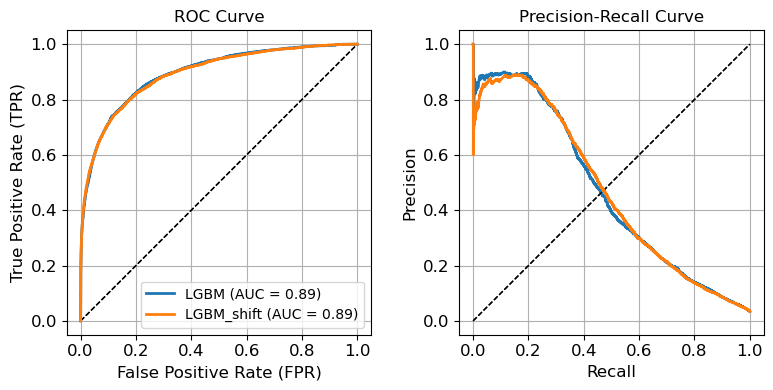

,Original,Remove
Precision,0.18,0.18
Recall,0.75,0.75
F1,0.29,0.29
ROC-AUC,0.89,0.89


In [1445]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))

# Metrics dataframe
model_metrics=[]


# Original Model
m = lgbm
# ROC curve
plot_roc_curve(metrics[m.name]['roc_curve'], metrics[m.name]['roc_auc_score'], model_name=m.name, color='C0', ax=ax[0])
# PR curve
plot_precision_recall_curve(metrics[m.name]['precision_recall_curve'], color='C0', ax=ax[1])

model_metrics.append([metrics[m.name]['precision_score'], 
                      metrics[m.name]['recall_score'], 
                      metrics[m.name]['f1_score'], 
                      metrics[m.name]['roc_auc_score']])

# Shifted model
m = model_shift
# ROC curve
plot_roc_curve(metrics_shift[m.name]['roc_curve'], metrics_shift[m.name]['roc_auc_score'], model_name=m.name, color='C1', ax=ax[0])
# PR curve
plot_precision_recall_curve(metrics_shift[m.name]['precision_recall_curve'], color='C1', ax=ax[1])

model_metrics.append([metrics_shift[m.name]['precision_score'], 
                      metrics_shift[m.name]['recall_score'], 
                      metrics_shift[m.name]['f1_score'], 
                      metrics_shift[m.name]['roc_auc_score']])



ax[0].set_aspect('equal')
ax[1].set_aspect('equal')

# plt.savefig(fig_folder+'roc_pr_curve.png', dpi=300)
plt.show()

display(pd.DataFrame(model_metrics, columns=['Precision', 'Recall', 'F1', 'ROC-AUC'], index=['Original', 'Remove']).round(2).T)

In [1446]:
[metrics_shift[m.name]['precision_score'], 
                      metrics_shift[m.name]['recall_score'], 
                      metrics_shift[m.name]['f1_score'], 
                      metrics_shift[m.name]['roc_auc_score']]

[0.17779343549997065,
 0.7450787401574803,
 0.28708224697795687,
 0.8932461316301595]

In [1449]:
[metrics['LGBM']['precision_score'], 
                      metrics['LGBM']['recall_score'], 
                      metrics['LGBM']['f1_score'], 
                      metrics['LGBM']['roc_auc_score']]

[0.1773148958515666,
 0.7477854330708661,
 0.2866575484601236,
 0.8949309718265253]

## Permutation Importance

In [110]:
def get_perm_imp(X, y, model_dict, scoring=None, n_reps=30, n_samples=1.0, random_state=1):
    perm_imp={}
    for m in model_dict:
        perm_imp[m] = permutation_importance(model_dict[m], X, y, 
                                             scoring=scoring,
                                             n_repeats=n_reps, 
                                             max_samples=n_samples, 
                                             random_state=random_state)
    return perm_imp

In [963]:
%%time
perm_imp = permutation_importance(lgbm, X_test, y_test, 
                                             scoring=['recall', 'precision'],
                                             n_repeats=10, 
                                             max_samples=1.0, 
                                             random_state=1)

CPU times: user 9min 39s, sys: 5min 24s, total: 15min 3s
Wall time: 1min 38s


In [1233]:
def plot_perm_imp(perm_imp, ax=None, model_name=None, feature_names=None, first=None):

    sorted_importances_idx = perm_imp.importances_mean.argsort()
    importances = pd.DataFrame(
        perm_imp.importances[sorted_importances_idx].T,
        columns=X_test.columns[sorted_importances_idx],
    )
    if feature_names:
        importances[feature_names[::-1]].plot.box(vert=False, whis=10, ax=ax)
    elif first:
        importances.iloc[:, -first:].plot.box(vert=False, whis=10, ax=ax)
    else:
        importances.plot.box(vert=False, whis=10, ax=ax)
    ax.axvline(x=0, color="k", linestyle="--")

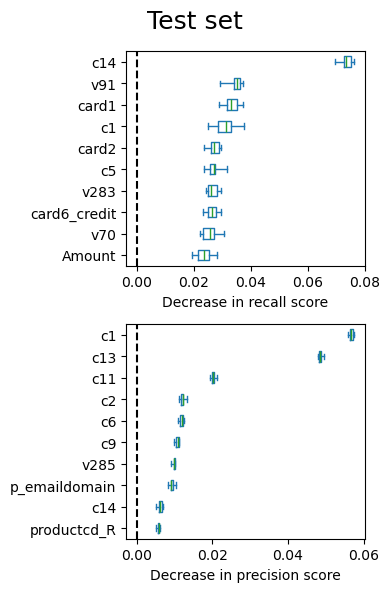

In [1238]:
fig, ax = plt.subplots(2, 1, figsize=(4, 6))

for i, metric in enumerate(['recall', 'precision']):
    plot_perm_imp(perm_imp[metric], model_name='LightGBM', ax=ax[i], first=10)#, feature_names=['c13', 'c1', 'Amount'])
    # ax[i].set_title('LightGBM', loc='left')
    ax[i].set_xlabel('Decrease in '+metric+' score')
    # ax[i,j].figure.tight_layout()
fig.suptitle('Test set', y=0.98, fontsize=18)
plt.tight_layout()
# plt.savefig(fig_folder+'permutation_importance_test.png', dpi=300, bbox_inches='tight')
plt.show()

# Notes
- Cross-validation of models
- Parameter tunning of models
- Advanced imputation methods, such as using predictive modeling (IterativeImputer)

<font size=5> References </font>

- About the dataset

https://www.kaggle.com/code/johnnytay/fraud-detection-with-vesta-dataset

https://www.kaggle.com/code/tanyildizderya/ieee-exploratory-data-analysis